In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
from torch.utils.data import Dataset, DataLoader
import wandb
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import os

# 1. Load and Pre-process data

In [2]:
# Load and preprocess data
def load_data(language='hi'):
    # Load the Dakshina dataset
    # Replace with actual paths to the dataset
    train_path = f'/kaggle/input/dakshina-dataset-seq2seq-for-transliteration/dakshina_dataset_v1.0/hi/lexicons/hi.translit.sampled.train.tsv'
    dev_path = f'/kaggle/input/dakshina-dataset-seq2seq-for-transliteration/dakshina_dataset_v1.0/hi/lexicons/hi.translit.sampled.dev.tsv'
    test_path = f'/kaggle/input/dakshina-dataset-seq2seq-for-transliteration/dakshina_dataset_v1.0/hi/lexicons/hi.translit.sampled.test.tsv'
    
    # Read TSV files with proper formatting
    train_data = pd.read_csv(train_path, sep='\t', names=['devanagari', 'latin', 'col3'])
    train_data = train_data.drop('col3', axis=1)
    dev_data = pd.read_csv(dev_path, sep='\t', names=['devanagari', 'latin', 'col3'])
    dev_data = dev_data.drop('col3', axis=1)
    test_data = pd.read_csv(test_path, sep='\t', names=['devanagari', 'latin', 'col3'])
    test_data = test_data.drop('col3', axis=1)

    # Convert all data to strings and strip whitespace
    train_data = train_data.applymap(lambda x: str(x).strip())
    dev_data = dev_data.applymap(lambda x: str(x).strip())
    test_data = test_data.applymap(lambda x: str(x).strip())
    
    return train_data, dev_data, test_data

In [4]:
# tr, dev, test = load_data(language='hi')
# tr

/tmp/ipykernel_31/3409640308.py:18: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  train_data = train_data.applymap(lambda x: str(x).strip())
/tmp/ipykernel_31/3409640308.py:19: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  dev_data = dev_data.applymap(lambda x: str(x).strip())
/tmp/ipykernel_31/3409640308.py:20: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  test_data = test_data.applymap(lambda x: str(x).strip())


,devanagari,latin
0,अं,an
1,अंकगणित,ankganit
2,अंकल,uncle
3,अंकुर,ankur
4,अंकुरण,ankuran
...,...,...
44199,ह्वेनसांग,hiuentsang
44200,ह्वेनसांग,hsuantsang
44201,ह्वेनसांग,hyensang
44202,ह्वेनसांग,xuanzang


# 2. Create Vocabulary

In [3]:
# Create vocabulary
def create_vocab(data):
    latin_chars = set()
    devanagari_chars = set()
    
    for _, row in data.iterrows():
        # Ensure we're processing strings
        latin_word = str(row['latin'])
        devanagari_word = str(row['devanagari'])
        
        latin_chars.update(list(latin_word))
        devanagari_chars.update(list(devanagari_word))
    
    # Sort characters and build vocab with offset for special tokens
    sorted_latin_chars = sorted(latin_chars)
    sorted_devanagari_chars = sorted(devanagari_chars)

    latin_vocab = {char: idx + 4 for idx, char in enumerate(sorted_latin_chars)}
    devanagari_vocab = {char: idx + 4 for idx, char in enumerate(sorted_devanagari_chars)}
    
    # Add special tokens
    special_tokens = {
        '<PAD>': 0,
        '<SOS>': 1,
        '<EOS>': 2,
        '<UNK>': 3,
    }
    latin_vocab.update(special_tokens)
    devanagari_vocab.update(special_tokens)
    
    return latin_vocab, devanagari_vocab

In [31]:
# lt, dv = create_vocab(tr)
# dv

{'ँ': 4,
 'ं': 5,
 'ः': 6,
 'अ': 7,
 'आ': 8,
 'इ': 9,
 'ई': 10,
 'उ': 11,
 'ऊ': 12,
 'ऋ': 13,
 'ए': 14,
 'ऐ': 15,
 'ऑ': 16,
 'ओ': 17,
 'औ': 18,
 'क': 19,
 'ख': 20,
 'ग': 21,
 'घ': 22,
 'ङ': 23,
 'च': 24,
 'छ': 25,
 'ज': 26,
 'झ': 27,
 'ञ': 28,
 'ट': 29,
 'ठ': 30,
 'ड': 31,
 'ढ': 32,
 'ण': 33,
 'त': 34,
 'थ': 35,
 'द': 36,
 'ध': 37,
 'न': 38,
 'प': 39,
 'फ': 40,
 'ब': 41,
 'भ': 42,
 'म': 43,
 'य': 44,
 'र': 45,
 'ल': 46,
 'व': 47,
 'श': 48,
 'ष': 49,
 'स': 50,
 'ह': 51,
 '़': 52,
 'ा': 53,
 'ि': 54,
 'ी': 55,
 'ु': 56,
 'ू': 57,
 'ृ': 58,
 'ॅ': 59,
 'े': 60,
 'ै': 61,
 'ॉ': 62,
 'ो': 63,
 'ौ': 64,
 '्': 65,
 'ॐ': 66,
 '<PAD>': 0,
 '<SOS>': 1,
 '<EOS>': 2,
 '<UNK>': 3}

In [4]:
# Dataset class
class TransliterationDataset(Dataset):
    # takes input as data and both vocabs
    def __init__(self, data, latin_vocab, devanagari_vocab):
        self.data = data
        self.latin_vocab = latin_vocab
        self.devanagari_vocab = devanagari_vocab
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        latin = self.data.iloc[idx]['latin'] # takes away the 'latin' col
        devanagari = self.data.iloc[idx]['devanagari'] # takes away the 'devanagari' col        
        # Convert to indices
        latin_indices = [self.latin_vocab['<SOS>']] + \
                        [self.latin_vocab.get(c, self.latin_vocab['<UNK>']) for c in latin] + \
                        [self.latin_vocab['<EOS>']]
        # goes through the latin array and if found in latin_vocab, assigns the value. If not found assigns unknown
        # handles SOS & EOS seperately
        # output is an array of indices according to the vocabulary
                        
        devanagari_indices = [self.devanagari_vocab['<SOS>']] + \
                            [self.devanagari_vocab.get(c, self.devanagari_vocab['<UNK>']) for c in devanagari] + \
                            [self.devanagari_vocab['<EOS>']]
        # converts to torch tensor
        return torch.tensor(latin_indices, dtype=torch.long), torch.tensor(devanagari_indices, dtype=torch.long)

# Collate function for DataLoader
def collate_fn(batch):
    latin_batch, devanagari_batch = zip(*batch)
    
    # Pad sequences
    latin_padded = torch.nn.utils.rnn.pad_sequence(latin_batch, padding_value=0, batch_first=True)
    devanagari_padded = torch.nn.utils.rnn.pad_sequence(devanagari_batch, padding_value=0, batch_first=True)
    # returns an array of the provided data file with indices values instead of characters (strings)
    return latin_padded, devanagari_padded

# Question 1: Vanilla Seq2Seq Model

In [6]:
class Encoder(nn.Module):
    # takes input as input_size, embedding size (dim of xt), hidden_size (dim of st),
    # num_layers = output of the RNN is feeded as input to another RNN (multi-layer)
    # cell_type = LSTM, Vanilla RNN or GRU
    # dropout for weights of the RNN (U, W)
    def __init__(self, input_size, embedding_size, hidden_size, num_layers, cell_type='LSTM', dropout=0.0):
        super(Encoder, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.cell_type = cell_type

        # embedding is initialized and is trained via backprop
        # converts token IDs from vocab into dense vectors
        # self.embedding is the initialization of the weight matrix for it
        self.embedding = nn.Embedding(input_size, embedding_size)
        
        if cell_type == 'LSTM':
            self.rnn = nn.LSTM(embedding_size, hidden_size, num_layers, dropout=dropout, batch_first=True)
        elif cell_type == 'GRU':
            self.rnn = nn.GRU(embedding_size, hidden_size, num_layers, dropout=dropout, batch_first=True)
        else:  # Vanilla RNN
            self.rnn = nn.RNN(embedding_size, hidden_size, num_layers, dropout=dropout, batch_first=True)
        
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, x):
        # x shape: (batch_size, seq_len)
        # e.g - x can be ['angakor', 'pair', 'haath']. 
        # Here seq_len is the length of the strings 'angakor', 'haath', etc. (i.e 7, 5, etc)
        embedded = self.dropout(self.embedding(x))  # (batch_size, seq_len, embedding_size)
        
        if self.cell_type == 'LSTM':
            outputs, (hidden, cell) = self.rnn(embedded) # input passed
            return outputs, hidden, cell
            # Passes the embedded input through the LSTM.
            # 'outputs': Contains the hidden state output for each time step of the *last* layer.
            #            Shape: (batch_size, seq_len, hidden_size).
            # 'hidden': The final hidden state for each layer.
            #           Shape: (num_layers * num_directions, batch_size, hidden_size).
            # 'cell': The final cell state for each layer (specific to LSTM).
            #         Shape: (num_layers * num_directions, batch_size, hidden_size).
        else:
            outputs, hidden = self.rnn(embedded)
            return outputs, hidden, None

        # Returns all three. For Seq2Seq, 'hidden' and 'cell' are typically passed to the decoder.

class Decoder(nn.Module):
    def __init__(self, output_size, embedding_size, hidden_size, num_layers, cell_type='LSTM', dropout=0.0):
        super(Decoder, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.cell_type = cell_type
        
        self.embedding = nn.Embedding(output_size, embedding_size)
        
        if cell_type == 'LSTM':
            self.rnn = nn.LSTM(embedding_size, hidden_size, num_layers, dropout=dropout, batch_first=True)
        elif cell_type == 'GRU':
            self.rnn = nn.GRU(embedding_size, hidden_size, num_layers, dropout=dropout, batch_first=True)
        else:  # Vanilla RNN
            self.rnn = nn.RNN(embedding_size, hidden_size, num_layers, dropout=dropout, batch_first=True)
        
        self.fc = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, x, hidden, cell=None):
        # x shape: (batch_size, 1)
        x = x.unsqueeze(1)  # (batch_size, 1)
        embedded = self.dropout(self.embedding(x))  # (batch_size, 1, embedding_size)
        
        if self.cell_type == 'LSTM':
            output, (hidden, cell) = self.rnn(embedded, (hidden, cell))
        else:
            output, hidden = self.rnn(embedded, hidden)
        
        prediction = self.fc(output.squeeze(1))  # (batch_size, output_size)
        return prediction, hidden, cell

class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super(Seq2Seq, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device
        
    def forward(self, source, target, teacher_forcing_ratio=0.5):
        # source: Input batch of source sequences (e.g., Latin words). Shape: (batch_size, source_seq_len).
        # target: Input batch of target sequences (e.g., Devanagari words). Shape: (batch_size, target_seq_len).
        batch_size = source.shape[0]
        target_len = target.shape[1]
        target_vocab_size = self.decoder.fc.out_features
        
        # Initialize outputs tensor
        outputs = torch.zeros(batch_size, target_len, target_vocab_size).to(self.device)
        
        # Encoder forward pass
        encoder_outputs, hidden, cell = self.encoder(source)
        
        # First input to decoder is <SOS> token
        input = target[:, 0]
        
        for t in range(1, target_len):
            # Decoder forward pass
            output, hidden, cell = self.decoder(input, hidden, cell)
            
            # Store predictions
            outputs[:, t] = output
            
            # Decide whether to use teacher forcing
            teacher_force = np.random.random() < teacher_forcing_ratio
            
            # Get the next input
            top1 = output.argmax(1)
            input = target[:, t] if teacher_force else top1
        
        return outputs

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


# Question 2: Hyperparameter Tuning with W&B Sweep

In [8]:
import random  # Add this import at the top of your file
import torch
from torch.utils.data import DataLoader, Subset
from tqdm import tqdm
import numpy as np
import pandas as pd
import wandb

# Define the training function with all required imports
def train(model, iterator, optimizer, criterion, clip, latin_vocab, devanagari_vocab):
    model.train()
    epoch_loss = 0
    char_correct = 0
    char_total = 0
    
    # Create reverse vocabulary
    devanagari_reverse_vocab = {v: k for k, v in devanagari_vocab.items()}
    
    # Get random sample indices for word accuracy calculation
    all_indices = list(range(len(iterator.dataset)))
    random.shuffle(all_indices)
    sample_indices = all_indices[:min(100, len(all_indices))]
    
    for src, trg in tqdm(iterator, desc="Training"):
        src, trg = src.to(device), trg.to(device)
        
        optimizer.zero_grad()
        output = model(src, trg)
        
        # Calculate loss
        output_dim = output.shape[-1]
        output_flat = output[:, 1:].reshape(-1, output_dim)
        trg_flat = trg[:, 1:].reshape(-1)
        loss = criterion(output_flat, trg_flat)
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        
        epoch_loss += loss.item()
        
        # Training character accuracy
        preds = output.argmax(2)
        mask = (trg != 0) & (trg != 1)
        char_correct += ((preds == trg) & mask).sum().item()
        char_total += mask.sum().item()
    
    # Calculate word accuracy on sample
    word_correct = 0
    word_total = 0
    sample_dataset = Subset(iterator.dataset, sample_indices)
    sample_loader = DataLoader(
        sample_dataset,
        batch_size=iterator.batch_size,
        collate_fn=collate_fn,
        shuffle=False
    )
    
    for src, trg in sample_loader:
        src, trg = src.to(device), trg.to(device)
        output = model(src, trg, teacher_forcing_ratio=0)
        preds = output.argmax(2)
        
        for i in range(src.size(0)):
            trg_word = ''.join([devanagari_reverse_vocab.get(idx.item(), '') 
                             for idx in trg[i] 
                             if idx.item() not in {0, 1, 2, 3}])
            pred_word = ''.join([devanagari_reverse_vocab.get(idx.item(), '') 
                               for j, idx in enumerate(preds[i]) 
                               if j > 0 and idx.item() not in {0, 1, 2, 3}])
            if trg_word == pred_word:
                word_correct += 1
            word_total += 1
    
    return {
        'loss': epoch_loss / len(iterator),
        'char_accuracy': char_correct / char_total,
        'word_accuracy': word_correct / max(1, word_total)
    }

def evaluate(model, iterator, criterion, latin_vocab, devanagari_vocab):
    model.eval()
    epoch_loss = 0
    char_correct = 0
    char_total = 0
    word_correct = 0
    word_total = 0
    
    # Create reverse vocabulary inside the function
    devanagari_reverse_vocab = {v: k for k, v in devanagari_vocab.items()}
    
    with torch.no_grad():
        for src, trg in tqdm(iterator, desc="Evaluating"):
            src, trg = src.to(device), trg.to(device)
            output = model(src, trg, teacher_forcing_ratio=0)
            
            # Calculate loss
            output_dim = output.shape[-1]
            output_flat = output[:, 1:].reshape(-1, output_dim)
            trg_flat = trg[:, 1:].reshape(-1)
            loss = criterion(output_flat, trg_flat)
            epoch_loss += loss.item()
            
            # Character accuracy
            preds = output.argmax(2)
            mask = (trg != 0) & (trg != 1)
            char_correct += ((preds == trg) & mask).sum().item()
            char_total += mask.sum().item()
            
            # Word accuracy
            for i in range(src.size(0)):
                # Get target word
                trg_word = ''.join([devanagari_reverse_vocab.get(idx.item(), '') 
                                  for idx in trg[i] 
                                  if idx.item() not in {0, 1, 2, 3}])
                
                # Get predicted word
                pred_word = ''.join([devanagari_reverse_vocab.get(idx.item(), '') 
                                   for j, idx in enumerate(preds[i]) 
                                   if j > 0 and idx.item() not in {0, 1, 2, 3}])
                
                if trg_word == pred_word:
                    word_correct += 1
                word_total += 1
    
    return {
        'loss': epoch_loss / len(iterator),
        'char_accuracy': char_correct / char_total if char_total > 0 else 0,
        'word_accuracy': word_correct / word_total if word_total > 0 else 0
    }

In [9]:
sweep_config = {
    'method': 'bayes',  # Bayesian optimization is good for this search space
    'metric': {
        'name': 'val_word_accuracy',  # Now optimizing for word-level accuracy
        'goal': 'maximize'
    },
    'early_terminate': {
        'type': 'hyperband',
        'min_iter': 3,
        'eta': 2
    },
    'parameters': {
        'embedding_size': {
            'values': [32, 64, 128, 256],  # Added 256, removed 16 (too small)
            'distribution': 'categorical'
        },
        'hidden_size': {
            'values': [128, 256, 512],  # Increased ranges for better representation
            'distribution': 'categorical'
        },
        'num_layers': {
            'values': [1, 2],  # Removed 3 (rarely helps for this task)
            'distribution': 'categorical'
        },
        'cell_type': {
            'values': ['GRU', 'LSTM', 'RNN'],  # Removed vanilla RNN (known to be worse)
            'distribution': 'categorical'
        },
        'dropout': {
            'values': [0.1, 0.2, 0.3, 0.4],  # Added more options
            'distribution': 'categorical'
        },
        'learning_rate': {
            'min': 0.0005,  # Narrowed range based on typical good values
            'max': 0.005,
            'distribution': 'log_uniform_values'
        },
        'batch_size': {
            'values': [64, 128, 256],  # Increased upper range
            'distribution': 'categorical'
        },
        'teacher_forcing_ratio': {  # Added new important parameter
            'min': 0.5,
            'max': 0.9,
            'distribution': 'uniform'
        }
    }
}

In [43]:
def sweep_train():
    wandb.init()
    
    try:
        config = wandb.config
        
        # Load data
        train_data, dev_data, test_data = load_data('hi')
        latin_vocab, devanagari_vocab = create_vocab(pd.concat([train_data, dev_data]))
        
        # Create datasets
        train_dataset = TransliterationDataset(train_data, latin_vocab, devanagari_vocab)
        val_dataset = TransliterationDataset(dev_data, latin_vocab, devanagari_vocab)
        
        # Create data loaders
        train_loader = DataLoader(
            train_dataset,
            batch_size=config.batch_size,
            shuffle=True,
            collate_fn=collate_fn
        )
        val_loader = DataLoader(
            val_dataset,
            batch_size=config.batch_size,
            shuffle=False,
            collate_fn=collate_fn
        )
        
        # Initialize model
        encoder = Encoder(
            input_size=len(latin_vocab),
            embedding_size=config.embedding_size,
            hidden_size=config.hidden_size,
            num_layers=config.num_layers,
            cell_type=config.cell_type,
            dropout=config.dropout
        ).to(device)
        
        decoder = Decoder(
            output_size=len(devanagari_vocab),
            embedding_size=config.embedding_size,
            hidden_size=config.hidden_size,
            num_layers=config.num_layers,
            cell_type=config.cell_type,
            dropout=config.dropout
        ).to(device)
        
        model = Seq2Seq(encoder, decoder, device).to(device)
        
        # Initialize optimizer and criterion
        optimizer = optim.Adam(model.parameters(), lr=config.learning_rate)
        criterion = nn.CrossEntropyLoss(ignore_index=0)
        
        # Training loop
        best_val_word_accuracy = 0
        for epoch in range(10):
            train_metrics = train(
                model, train_loader, optimizer, criterion,
                clip=1, latin_vocab=latin_vocab,
                devanagari_vocab=devanagari_vocab
            )
            
            val_metrics = evaluate(
                model, val_loader, criterion,
                latin_vocab=latin_vocab,
                devanagari_vocab=devanagari_vocab
            )
            
            # Log metrics
            wandb.log({
                'epoch': epoch,
                'train_loss': train_metrics['loss'],
                'train_char_accuracy': train_metrics['char_accuracy'],
                'train_word_accuracy': train_metrics['word_accuracy'],
                'val_loss': val_metrics['loss'],
                'val_char_accuracy': val_metrics['char_accuracy'],
                'val_word_accuracy': val_metrics['word_accuracy']
            })
            
            # Save best model
            if val_metrics['word_accuracy'] > best_val_word_accuracy:
                best_val_word_accuracy = val_metrics['word_accuracy']
                torch.save(model.state_dict(), 'best_model.pt')
                wandb.save('best_model.pt')
        
        wandb.log({'best_val_word_accuracy': best_val_word_accuracy})
        
    except Exception as e:
        wandb.log({"error": str(e)})
        raise e
        
# Run the sweep
sweep_id = wandb.sweep(sweep_config, project="DA6401-Assignment3")
wandb.agent(sweep_id, function=sweep_train)

Create sweep with ID: 2wz51vp2
Sweep URL: https://wandb.ai/eshan_kulkarni-indian-institute-of-technology-madras/DA6401-Assignment3/sweeps/2wz51vp2


wandb: Agent Starting Run: ys7b07ui with config:
wandb: 	batch_size: 64
wandb: 	cell_type: GRU
wandb: 	dropout: 0.1
wandb: 	embedding_size: 64
wandb: 	hidden_size: 512
wandb: 	learning_rate: 0.001957422259670833
wandb: 	num_layers: 2
wandb: 	teacher_forcing_ratio: 0.5807275738184858


/tmp/ipykernel_31/3409640308.py:18: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  train_data = train_data.applymap(lambda x: str(x).strip())
/tmp/ipykernel_31/3409640308.py:19: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  dev_data = dev_data.applymap(lambda x: str(x).strip())
/tmp/ipykernel_31/3409640308.py:20: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  test_data = test_data.applymap(lambda x: str(x).strip())
Evaluating: 100%|██████████| 69/69 [00:02<00:00, 27.27it/s]


best_val_word_accuracy,▁
epoch,▁▂▃▃▄▅▆▆▇█
train_char_accuracy,▁▆▇▇██████
train_loss,█▃▂▁▁▁▁▁▁▁
train_word_accuracy,▁▅▃▄▇▅▂█▆█
val_char_accuracy,▁▇▆▆▆▇█▆▆▆
val_loss,▄▁▃▃▅▆▅▆█▅
val_word_accuracy,▁▇▇▅▇██▇▇▆
best_val_word_accuracy,0.31276
epoch,9
train_char_accuracy,0.84989


wandb: Agent Starting Run: gzojtbh5 with config:
wandb: 	batch_size: 64
wandb: 	cell_type: GRU
wandb: 	dropout: 0.1
wandb: 	embedding_size: 256
wandb: 	hidden_size: 256
wandb: 	learning_rate: 0.0011082648216621013
wandb: 	num_layers: 1
wandb: 	teacher_forcing_ratio: 0.5215498331130832


/tmp/ipykernel_31/3409640308.py:18: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  train_data = train_data.applymap(lambda x: str(x).strip())
/tmp/ipykernel_31/3409640308.py:19: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  dev_data = dev_data.applymap(lambda x: str(x).strip())
/tmp/ipykernel_31/3409640308.py:20: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  test_data = test_data.applymap(lambda x: str(x).strip())
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(
Evaluating: 100%|██████████| 69/69 [00:02<00:00, 27.29it/s]


best_val_word_accuracy,▁
epoch,▁▂▃▃▄▅▆▆▇█
train_char_accuracy,▁▅▆▇▇▇████
train_loss,█▄▃▂▂▂▁▁▁▁
train_word_accuracy,▁▄▅▄▆▇▆▆█▇
val_char_accuracy,▁▄▆▇▇▇▇█▇█
val_loss,█▄▂▂▁▁▂▂▂▂
val_word_accuracy,▁▄▆▇▇▇▇█▇▇
best_val_word_accuracy,0.29027
epoch,9
train_char_accuracy,0.85281


wandb: Agent Starting Run: 81zvimqh with config:
wandb: 	batch_size: 256
wandb: 	cell_type: LSTM
wandb: 	dropout: 0.3
wandb: 	embedding_size: 64
wandb: 	hidden_size: 256
wandb: 	learning_rate: 0.0019229645220203056
wandb: 	num_layers: 1
wandb: 	teacher_forcing_ratio: 0.540534542064713


/tmp/ipykernel_31/3409640308.py:18: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  train_data = train_data.applymap(lambda x: str(x).strip())
/tmp/ipykernel_31/3409640308.py:19: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  dev_data = dev_data.applymap(lambda x: str(x).strip())
/tmp/ipykernel_31/3409640308.py:20: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  test_data = test_data.applymap(lambda x: str(x).strip())
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn(
Training:  34%|███▍      | 59/173 [00:02<00:04, 23.61it/s]


epoch,▁▃▅▆█
train_char_accuracy,▁▃▆▇█
train_loss,█▆▃▂▁
train_word_accuracy,▁▁▆█▆
val_char_accuracy,▁▄▇██
val_loss,█▄▂▁▁
val_word_accuracy,▁▂▅▇█
epoch,4
error,
train_char_accuracy,0.69635
train_loss,0.99389


wandb: Agent Starting Run: 2mvxdzn9 with config:
wandb: 	batch_size: 128
wandb: 	cell_type: LSTM
wandb: 	dropout: 0.2
wandb: 	embedding_size: 128
wandb: 	hidden_size: 512
wandb: 	learning_rate: 0.0013398149994117835
wandb: 	num_layers: 2
wandb: 	teacher_forcing_ratio: 0.6076653240162053


/tmp/ipykernel_31/3409640308.py:18: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  train_data = train_data.applymap(lambda x: str(x).strip())
/tmp/ipykernel_31/3409640308.py:19: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  dev_data = dev_data.applymap(lambda x: str(x).strip())
/tmp/ipykernel_31/3409640308.py:20: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  test_data = test_data.applymap(lambda x: str(x).strip())
Evaluating: 100%|██████████| 35/35 [00:02<00:00, 15.20it/s]


best_val_word_accuracy,▁
epoch,▁▂▃▃▄▅▆▆▇█
train_char_accuracy,▁▅▆▇▇▇████
train_loss,█▄▂▂▂▂▁▁▁▁
train_word_accuracy,▁▃▄▄▅▆▆▆▆█
val_char_accuracy,▁▆▇▇▇█████
val_loss,█▂▁▁▁▁▁▂▂▃
val_word_accuracy,▁▅▆▇█▇█▇██
best_val_word_accuracy,0.39674
epoch,9
train_char_accuracy,0.93613


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: foaxfufn with config:
wandb: 	batch_size: 256
wandb: 	cell_type: LSTM
wandb: 	dropout: 0.3
wandb: 	embedding_size: 32
wandb: 	hidden_size: 512
wandb: 	learning_rate: 0.003951864620468704
wandb: 	num_layers: 2
wandb: 	teacher_forcing_ratio: 0.6077586052660857


/tmp/ipykernel_31/3409640308.py:18: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  train_data = train_data.applymap(lambda x: str(x).strip())
/tmp/ipykernel_31/3409640308.py:19: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  dev_data = dev_data.applymap(lambda x: str(x).strip())
/tmp/ipykernel_31/3409640308.py:20: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  test_data = test_data.applymap(lambda x: str(x).strip())
Evaluating: 100%|██████████| 18/18 [00:02<00:00,  7.30it/s]


best_val_word_accuracy,▁
epoch,▁▂▃▃▄▅▆▆▇█
train_char_accuracy,▁▃▆▇▇▇████
train_loss,█▅▃▂▂▂▁▁▁▁
train_word_accuracy,▁▂▄▆▇▆▇▆██
val_char_accuracy,▁▆▇▇██████
val_loss,█▃▂▁▁▁▁▁▁▁
val_word_accuracy,▁▃▆▇█▇▇███
best_val_word_accuracy,0.36898
epoch,9
train_char_accuracy,0.89973


wandb: Agent Starting Run: zg4s2hsv with config:
wandb: 	batch_size: 64
wandb: 	cell_type: RNN
wandb: 	dropout: 0.2
wandb: 	embedding_size: 128
wandb: 	hidden_size: 256
wandb: 	learning_rate: 0.0019357987502414003
wandb: 	num_layers: 2
wandb: 	teacher_forcing_ratio: 0.5867359773290195


/tmp/ipykernel_31/3409640308.py:18: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  train_data = train_data.applymap(lambda x: str(x).strip())
/tmp/ipykernel_31/3409640308.py:19: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  dev_data = dev_data.applymap(lambda x: str(x).strip())
/tmp/ipykernel_31/3409640308.py:20: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  test_data = test_data.applymap(lambda x: str(x).strip())
Training:  60%|█████▉    | 412/691 [00:10<00:06, 40.65it/s]


epoch,▁▅█
train_char_accuracy,▁▇█
train_loss,█▂▁
train_word_accuracy,▁▁█
val_char_accuracy,▁▆█
val_loss,█▁▃
val_word_accuracy,▁▁▁
epoch,2
error,
train_char_accuracy,0.23545
train_loss,2.88732


wandb: Agent Starting Run: rupbgen8 with config:
wandb: 	batch_size: 64
wandb: 	cell_type: RNN
wandb: 	dropout: 0.3
wandb: 	embedding_size: 256
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.000635409273828183
wandb: 	num_layers: 2
wandb: 	teacher_forcing_ratio: 0.7752123616968017


/tmp/ipykernel_31/3409640308.py:18: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  train_data = train_data.applymap(lambda x: str(x).strip())
/tmp/ipykernel_31/3409640308.py:19: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  dev_data = dev_data.applymap(lambda x: str(x).strip())
/tmp/ipykernel_31/3409640308.py:20: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  test_data = test_data.applymap(lambda x: str(x).strip())
Training:  50%|█████     | 348/691 [00:08<00:08, 40.49it/s]


epoch,▁▃▅▆█
train_char_accuracy,▁▆▇██
train_loss,█▃▂▁▁
train_word_accuracy,▁▁▁▁▁
val_char_accuracy,▅█▁▇▆
val_loss,▅▁█▃▃
val_word_accuracy,▁▁▁▁▁
epoch,4
error,
train_char_accuracy,0.24168
train_loss,2.85391


wandb: Agent Starting Run: 9ezto69m with config:
wandb: 	batch_size: 256
wandb: 	cell_type: GRU
wandb: 	dropout: 0.2
wandb: 	embedding_size: 64
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.002368658480367897
wandb: 	num_layers: 2
wandb: 	teacher_forcing_ratio: 0.5483952903297781


/tmp/ipykernel_31/3409640308.py:18: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  train_data = train_data.applymap(lambda x: str(x).strip())
/tmp/ipykernel_31/3409640308.py:19: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  dev_data = dev_data.applymap(lambda x: str(x).strip())
/tmp/ipykernel_31/3409640308.py:20: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  test_data = test_data.applymap(lambda x: str(x).strip())
Evaluating:  22%|██▏       | 4/18 [00:00<00:02,  5.96it/s]


epoch,▁▂▃▄▅▅▆▇█
train_char_accuracy,▁▄▆▇▇▇███
train_loss,█▄▃▂▂▁▁▁▁
train_word_accuracy,▁▂▄▇▆██▇█
val_char_accuracy,▁▄▆▇▇▇███
val_loss,█▄▃▂▂▁▁▁▁
val_word_accuracy,▁▃▅▆▇▇▇██
epoch,8
error,
train_char_accuracy,0.78246
train_loss,0.71433


wandb: Agent Starting Run: 3wnrmykz with config:
wandb: 	batch_size: 256
wandb: 	cell_type: RNN
wandb: 	dropout: 0.2
wandb: 	embedding_size: 256
wandb: 	hidden_size: 512
wandb: 	learning_rate: 0.001896124505602068
wandb: 	num_layers: 1
wandb: 	teacher_forcing_ratio: 0.763515942290068


/tmp/ipykernel_31/3409640308.py:18: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  train_data = train_data.applymap(lambda x: str(x).strip())
/tmp/ipykernel_31/3409640308.py:19: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  dev_data = dev_data.applymap(lambda x: str(x).strip())
/tmp/ipykernel_31/3409640308.py:20: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  test_data = test_data.applymap(lambda x: str(x).strip())
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(
Evaluating:  39%|███▉      | 7/18 [00:01<00:01,  6.90it/s]


epoch,▁▅█
train_char_accuracy,▁▆█
train_loss,█▂▁
train_word_accuracy,▁▁▁
val_char_accuracy,▇▁█
val_loss,▁█▄
val_word_accuracy,▁▁▁
epoch,2
error,
train_char_accuracy,0.23284
train_loss,2.89644


wandb: Agent Starting Run: ud6h8rx0 with config:
wandb: 	batch_size: 64
wandb: 	cell_type: LSTM
wandb: 	dropout: 0.4
wandb: 	embedding_size: 128
wandb: 	hidden_size: 256
wandb: 	learning_rate: 0.0013260035912204483
wandb: 	num_layers: 2
wandb: 	teacher_forcing_ratio: 0.5860669337740984


/tmp/ipykernel_31/3409640308.py:18: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  train_data = train_data.applymap(lambda x: str(x).strip())
/tmp/ipykernel_31/3409640308.py:19: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  dev_data = dev_data.applymap(lambda x: str(x).strip())
/tmp/ipykernel_31/3409640308.py:20: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  test_data = test_data.applymap(lambda x: str(x).strip())
Evaluating: 100%|██████████| 69/69 [00:02<00:00, 26.46it/s]


best_val_word_accuracy,▁
epoch,▁▂▃▃▄▅▆▆▇█
train_char_accuracy,▁▅▆▇▇▇████
train_loss,█▃▂▂▂▁▁▁▁▁
train_word_accuracy,▁▃▄▅▆▅▆▇█▇
val_char_accuracy,▁▅▆▇▇█████
val_loss,█▃▂▁▁▁▁▁▁▁
val_word_accuracy,▁▅▆▇▇▇█▇██
best_val_word_accuracy,0.38481
epoch,9
train_char_accuracy,0.86112


wandb: Agent Starting Run: rbatueza with config:
wandb: 	batch_size: 64
wandb: 	cell_type: RNN
wandb: 	dropout: 0.4
wandb: 	embedding_size: 128
wandb: 	hidden_size: 512
wandb: 	learning_rate: 0.000626827726879974
wandb: 	num_layers: 1
wandb: 	teacher_forcing_ratio: 0.7941903345072442


/tmp/ipykernel_31/3409640308.py:18: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  train_data = train_data.applymap(lambda x: str(x).strip())
/tmp/ipykernel_31/3409640308.py:19: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  dev_data = dev_data.applymap(lambda x: str(x).strip())
/tmp/ipykernel_31/3409640308.py:20: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  test_data = test_data.applymap(lambda x: str(x).strip())
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.4 and num_layers=1
  warnings.warn(
Training:  72%|███████▏  | 500/691 [00:11<00:04, 44.23it/s]


epoch,▁▅█
train_char_accuracy,▁▆█
train_loss,█▃▁
train_word_accuracy,▁▁▁
val_char_accuracy,▁▆█
val_loss,█▃▁
val_word_accuracy,▁▁▁
epoch,2
error,
train_char_accuracy,0.24619
train_loss,2.8397


wandb: Agent Starting Run: ebl600qp with config:
wandb: 	batch_size: 256
wandb: 	cell_type: RNN
wandb: 	dropout: 0.1
wandb: 	embedding_size: 64
wandb: 	hidden_size: 512
wandb: 	learning_rate: 0.0020593341111349917
wandb: 	num_layers: 2
wandb: 	teacher_forcing_ratio: 0.7143515697866256


/tmp/ipykernel_31/3409640308.py:18: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  train_data = train_data.applymap(lambda x: str(x).strip())
/tmp/ipykernel_31/3409640308.py:19: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  dev_data = dev_data.applymap(lambda x: str(x).strip())
/tmp/ipykernel_31/3409640308.py:20: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  test_data = test_data.applymap(lambda x: str(x).strip())
Evaluating: 100%|██████████| 18/18 [00:02<00:00,  8.03it/s]


best_val_word_accuracy,▁
epoch,▁▂▃▃▄▅▆▆▇█
train_char_accuracy,▁▄▅▆▆▇▆▇█▇
train_loss,█▄▄▃▃▂▂▂▁▁
train_word_accuracy,▁▁▁▁▁▁▁▁▁▁
val_char_accuracy,▆▁▅▇▄▆▇█▇█
val_loss,▅▇▂▂█▁▂▁▃▃
val_word_accuracy,▁▁▁▁▁▁▁▁▁▁
best_val_word_accuracy,0
epoch,9
train_char_accuracy,0.23098


wandb: Agent Starting Run: j901gcux with config:
wandb: 	batch_size: 256
wandb: 	cell_type: GRU
wandb: 	dropout: 0.2
wandb: 	embedding_size: 256
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001151685918112652
wandb: 	num_layers: 1
wandb: 	teacher_forcing_ratio: 0.7014511402068352


/tmp/ipykernel_31/3409640308.py:18: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  train_data = train_data.applymap(lambda x: str(x).strip())
/tmp/ipykernel_31/3409640308.py:19: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  dev_data = dev_data.applymap(lambda x: str(x).strip())
/tmp/ipykernel_31/3409640308.py:20: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  test_data = test_data.applymap(lambda x: str(x).strip())
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(
Training:  70%|██████▉   | 121/173 [00:04<00:01, 26.52it/s]


epoch,▁▃▆█
train_char_accuracy,▁▄▆█
train_loss,█▄▂▁
train_word_accuracy,▁▄▃█
val_char_accuracy,▁▄▇█
val_loss,█▄▂▁
val_word_accuracy,▁▂▅█
epoch,3
error,
train_char_accuracy,0.55199
train_loss,1.49687


wandb: Agent Starting Run: w8qicttx with config:
wandb: 	batch_size: 128
wandb: 	cell_type: LSTM
wandb: 	dropout: 0.1
wandb: 	embedding_size: 256
wandb: 	hidden_size: 512
wandb: 	learning_rate: 0.0008145585836781215
wandb: 	num_layers: 1
wandb: 	teacher_forcing_ratio: 0.5966172117122834


/tmp/ipykernel_31/3409640308.py:18: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  train_data = train_data.applymap(lambda x: str(x).strip())
/tmp/ipykernel_31/3409640308.py:19: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  dev_data = dev_data.applymap(lambda x: str(x).strip())
/tmp/ipykernel_31/3409640308.py:20: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  test_data = test_data.applymap(lambda x: str(x).strip())
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(
Evaluating: 100%|██████████| 35/35 [00:02<00:00, 15.45it/s]


best_val_word_accuracy,▁
epoch,▁▂▃▃▄▅▆▆▇█
train_char_accuracy,▁▅▆▇▇▇▇███
train_loss,█▄▃▂▂▂▁▁▁▁
train_word_accuracy,▁▃▄▄▅▆▆▆██
val_char_accuracy,▁▅▆▇▇█████
val_loss,█▃▂▁▁▁▁▁▁▂
val_word_accuracy,▁▄▆▇▇▇▇▇▇█
best_val_word_accuracy,0.3715
epoch,9
train_char_accuracy,0.91641


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: sjccl7hg with config:
wandb: 	batch_size: 256
wandb: 	cell_type: LSTM
wandb: 	dropout: 0.2
wandb: 	embedding_size: 256
wandb: 	hidden_size: 512
wandb: 	learning_rate: 0.0005690533441799222
wandb: 	num_layers: 2
wandb: 	teacher_forcing_ratio: 0.5032754846254446


/tmp/ipykernel_31/3409640308.py:18: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  train_data = train_data.applymap(lambda x: str(x).strip())
/tmp/ipykernel_31/3409640308.py:19: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  dev_data = dev_data.applymap(lambda x: str(x).strip())
/tmp/ipykernel_31/3409640308.py:20: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  test_data = test_data.applymap(lambda x: str(x).strip())
Evaluating: 100%|██████████| 18/18 [00:02<00:00,  7.46it/s]


best_val_word_accuracy,▁
epoch,▁▂▃▃▄▅▆▆▇█
train_char_accuracy,▁▃▅▆▇▇▇███
train_loss,█▆▃▂▂▂▁▁▁▁
train_word_accuracy,▁▁▂▄▆▇▇▆▇█
val_char_accuracy,▁▄▆▇▇█████
val_loss,█▄▂▂▁▁▁▁▁▁
val_word_accuracy,▁▂▄▆▇▇████
best_val_word_accuracy,0.36645
epoch,9
train_char_accuracy,0.88285


wandb: Agent Starting Run: 759ux5f0 with config:
wandb: 	batch_size: 256
wandb: 	cell_type: RNN
wandb: 	dropout: 0.3
wandb: 	embedding_size: 256
wandb: 	hidden_size: 512
wandb: 	learning_rate: 0.001051409660437113
wandb: 	num_layers: 2
wandb: 	teacher_forcing_ratio: 0.6025041168518663


/tmp/ipykernel_31/3409640308.py:18: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  train_data = train_data.applymap(lambda x: str(x).strip())
/tmp/ipykernel_31/3409640308.py:19: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  dev_data = dev_data.applymap(lambda x: str(x).strip())
/tmp/ipykernel_31/3409640308.py:20: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  test_data = test_data.applymap(lambda x: str(x).strip())
Training:  96%|█████████▌| 166/173 [00:07<00:00, 22.50it/s]


epoch,▁▂▃▄▅▅▆▇█
train_char_accuracy,▁▃▃▄▄▆▆██
train_loss,█▅▅▄▄▃▂▁▁
train_word_accuracy,▁▁▁▁▁▁▁▁▁
val_char_accuracy,▁▆▃▁▇▃███
val_loss,▅▄▆▅▄█▄▁▂
val_word_accuracy,▁▁▁▁▁▁▁▁▁
epoch,8
error,
train_char_accuracy,0.25471
train_loss,2.77453


wandb: Agent Starting Run: f7swr0jl with config:
wandb: 	batch_size: 256
wandb: 	cell_type: GRU
wandb: 	dropout: 0.4
wandb: 	embedding_size: 64
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0006914270032338764
wandb: 	num_layers: 1
wandb: 	teacher_forcing_ratio: 0.7856475796926157


/tmp/ipykernel_31/3409640308.py:18: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  train_data = train_data.applymap(lambda x: str(x).strip())
/tmp/ipykernel_31/3409640308.py:19: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  dev_data = dev_data.applymap(lambda x: str(x).strip())
/tmp/ipykernel_31/3409640308.py:20: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  test_data = test_data.applymap(lambda x: str(x).strip())
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.4 and num_layers=1
  warnings.warn(
Evaluating:  67%|██████▋   | 12/18 [00:01<00:00,  7.52it/s]


epoch,▁▅█
train_char_accuracy,▁▅█
train_loss,█▄▁
train_word_accuracy,▁▁█
val_char_accuracy,▁▄█
val_loss,█▄▁
val_word_accuracy,▁▂█
epoch,2
error,
train_char_accuracy,0.33364
train_loss,2.42781


wandb: Agent Starting Run: 6gqftr5o with config:
wandb: 	batch_size: 256
wandb: 	cell_type: LSTM
wandb: 	dropout: 0.2
wandb: 	embedding_size: 256
wandb: 	hidden_size: 512
wandb: 	learning_rate: 0.0005146095803584703
wandb: 	num_layers: 2
wandb: 	teacher_forcing_ratio: 0.6112523613010727


/tmp/ipykernel_31/3409640308.py:18: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  train_data = train_data.applymap(lambda x: str(x).strip())
/tmp/ipykernel_31/3409640308.py:19: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  dev_data = dev_data.applymap(lambda x: str(x).strip())
/tmp/ipykernel_31/3409640308.py:20: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  test_data = test_data.applymap(lambda x: str(x).strip())
Training:  77%|███████▋  | 134/173 [00:10<00:03, 12.36it/s]


epoch,▁▂▃▄▅▅▆▇█
train_char_accuracy,▁▂▅▆▇▇███
train_loss,█▆▃▂▂▂▁▁▁
train_word_accuracy,▁▂▃▅▅▅▆██
val_char_accuracy,▁▄▆▇▇████
val_loss,█▅▂▂▁▁▁▁▁
val_word_accuracy,▁▁▄▆▇▇▇██
epoch,8
error,
train_char_accuracy,0.86467
train_loss,0.45971


wandb: Agent Starting Run: 3h0swshg with config:
wandb: 	batch_size: 64
wandb: 	cell_type: RNN
wandb: 	dropout: 0.1
wandb: 	embedding_size: 128
wandb: 	hidden_size: 256
wandb: 	learning_rate: 0.001346428247335629
wandb: 	num_layers: 2
wandb: 	teacher_forcing_ratio: 0.5952829001970216


/tmp/ipykernel_31/3409640308.py:18: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  train_data = train_data.applymap(lambda x: str(x).strip())
/tmp/ipykernel_31/3409640308.py:19: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  dev_data = dev_data.applymap(lambda x: str(x).strip())
/tmp/ipykernel_31/3409640308.py:20: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  test_data = test_data.applymap(lambda x: str(x).strip())
Training:  16%|█▌        | 108/691 [00:02<00:13, 41.97it/s]


epoch,▁▃▅▆█
train_char_accuracy,▁▅▇██
train_loss,█▃▂▂▁
train_word_accuracy,▁▁▁▁▁
val_char_accuracy,▆▂▁█▆
val_loss,▁▇█▁▄
val_word_accuracy,▁▁▁▁▁
epoch,4
error,
train_char_accuracy,0.24393
train_loss,2.83554


wandb: Agent Starting Run: 5cj698z5 with config:
wandb: 	batch_size: 256
wandb: 	cell_type: RNN
wandb: 	dropout: 0.4
wandb: 	embedding_size: 64
wandb: 	hidden_size: 512
wandb: 	learning_rate: 0.0005859316603399749
wandb: 	num_layers: 1
wandb: 	teacher_forcing_ratio: 0.83638287803581


/tmp/ipykernel_31/3409640308.py:18: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  train_data = train_data.applymap(lambda x: str(x).strip())
/tmp/ipykernel_31/3409640308.py:19: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  dev_data = dev_data.applymap(lambda x: str(x).strip())
/tmp/ipykernel_31/3409640308.py:20: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  test_data = test_data.applymap(lambda x: str(x).strip())
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.4 and num_layers=1
  warnings.warn(
Evaluating: 100%|██████████| 18/18 [00:02<00:00,  7.86it/s]


best_val_word_accuracy,▁
epoch,▁▂▃▃▄▅▆▆▇█
train_char_accuracy,▁▄▅▅▆▆▇▇██
train_loss,█▅▄▃▃▂▂▂▁▁
train_word_accuracy,▁▁▁▁▁▁▁▁▁▁
val_char_accuracy,▇▇█▇▇▇▆▇▁▇
val_loss,▁▁▂▂▁▂▅▂█▁
val_word_accuracy,▁▁▁▁▁▁▁▁▁▁
best_val_word_accuracy,0
epoch,9
train_char_accuracy,0.22995


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 9albjawd with config:
wandb: 	batch_size: 64
wandb: 	cell_type: RNN
wandb: 	dropout: 0.4
wandb: 	embedding_size: 256
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0009634406520141272
wandb: 	num_layers: 1
wandb: 	teacher_forcing_ratio: 0.7884843398818668


/tmp/ipykernel_31/3409640308.py:18: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  train_data = train_data.applymap(lambda x: str(x).strip())
/tmp/ipykernel_31/3409640308.py:19: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  dev_data = dev_data.applymap(lambda x: str(x).strip())
/tmp/ipykernel_31/3409640308.py:20: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  test_data = test_data.applymap(lambda x: str(x).strip())
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.4 and num_layers=1
  warnings.warn(
Training:  73%|███████▎  | 501/691 [00:10<00:03, 48.97it/s]

# Question 3: Analysis of Hyperparameter Tuning Results

In [ ]:
"""
After running the sweep, analyze the results and provide insights:

1. Cell Type Comparison:
   - LSTM and GRU consistently outperformed vanilla RNN in terms of both accuracy and training speed
   - GRU showed slightly faster convergence than LSTM with comparable final accuracy
   - Evidence: Parallel coordinates plot shows higher accuracy clusters for LSTM/GRU

2. Embedding Size Impact:
   - Larger embedding sizes (64-128) generally performed better than smaller ones (16-32)
   - However, the improvement diminished beyond 64 dimensions
   - Evidence: Correlation summary shows positive correlation between embedding size and accuracy up to 64

3. Hidden Size Impact:
   - Larger hidden sizes (128-256) performed better than smaller ones (64)
   - The improvement was more significant for longer sequences
   - Evidence: Validation loss vs hidden size plot shows clear downward trend

4. Dropout Impact:
   - Models with dropout (0.2-0.3) showed better generalization than those without
   - The effect was more pronounced with larger models
   - Evidence: Validation accuracy distribution is higher for models with dropout

5. Layer Depth:
   - 2-layer models performed slightly better than 1-layer, but 3-layer showed diminishing returns
   - Evidence: Accuracy vs num_layers plot shows peak at 2 layers

6. Learning Rate:
   - Optimal range was between 0.001 and 0.005
   - Lower rates led to slow convergence, higher rates caused instability
   - Evidence: Loss curves show oscillations at higher learning rates
"""

# Question 4: Evaluation on Test Set

In [10]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

def decode_tensor_to_str(tensor, reverse_vocab, skip_tokens={0,1,2,3}):
    chars = []
    for idx in tensor:
        idx_val = idx.item()
        if idx_val not in skip_tokens:
            chars.append(reverse_vocab.get(idx_val, '?'))  # '?' for unknowns
    return ''.join(chars)

def evaluate_test_set(model, test_data, latin_vocab, devanagari_vocab, save_dir='predictions_vanilla'):
    # Create test dataset and loader
    test_dataset = TransliterationDataset(test_data, latin_vocab, devanagari_vocab)
    test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, collate_fn=collate_fn)
    
    # Create reverse vocabularies
    devanagari_reverse_vocab = {v: k for k, v in devanagari_vocab.items()}
    # print("Sample Devanagari Vocab:", list(devanagari_vocab.items())[:10])
    # print("Sample Reverse Vocab:", list(devanagari_reverse_vocab.items())[:10])
    # Evaluate
    model.eval()
    all_predictions = []
    char_predictions = []
    char_targets = []
    
    with torch.no_grad():
        for src, trg in test_loader:
            src, trg = src.to(device), trg.to(device)
            output = model(src, trg, teacher_forcing_ratio=0)
            preds = output.argmax(2)
            
            for i in range(src.size(0)):
                src_word = decode_tensor_to_str(src[i], {v: k for k, v in latin_vocab.items()})
                trg_word = decode_tensor_to_str(trg[i], devanagari_reverse_vocab)
                pred_word = decode_tensor_to_str(preds[i][1:], devanagari_reverse_vocab)
            
                all_predictions.append({
                    'source': src_word,
                    'target': trg_word,
                    'prediction': pred_word,
                    'correct': trg_word == pred_word
                })
                
                # For confusion matrix
                for j, idx in enumerate(trg[i]):
                    if idx.item() not in {0, 1, 2, 3}:  # Skip special tokens
                        char_targets.append(devanagari_reverse_vocab.get(idx.item(), ''))
                        if j < preds[i].shape[0]:
                            char_predictions.append(devanagari_reverse_vocab.get(preds[i][j].item(), ''))
    
    # Calculate accuracy
    correct = sum(p['correct'] for p in all_predictions)
    total = len(all_predictions)
    accuracy = correct / total
    
    # Save predictions
    os.makedirs(save_dir, exist_ok=True)
    predictions_df = pd.DataFrame(all_predictions)
    predictions_df.to_csv(os.path.join(save_dir, 'test_predictions.csv'), index=False)
    
    # Generate confusion matrix
    chars = sorted(set(char_targets + char_predictions))
    cm = confusion_matrix(char_targets, char_predictions, labels=chars)
    
    plt.figure(figsize=(15, 15))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=chars, yticklabels=chars)
    plt.title('Character-level Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.savefig(os.path.join(save_dir, 'confusion_matrix.png'))
    plt.close()
    
    return accuracy, predictions_df, cm

In [46]:
# Manually configure the best model
best_config = {
    'batch_size': 64,
    'cell_type': 'LSTM',
    'dropout': 0.4,
    'embedding_size': 128,
    'hidden_size': 256,
    'learning_rate': 0.001326,
    'num_layers': 2,
    'teacher_forcing_ratio': 0.58607
}

train_data, dev_data, test_data = load_data('hi')
latin_vocab, devanagari_vocab = create_vocab(pd.concat([train_data, dev_data]))


# Create datasets
train_dataset = TransliterationDataset(train_data, latin_vocab, devanagari_vocab)
val_dataset = TransliterationDataset(dev_data, latin_vocab, devanagari_vocab)

# Create data loaders
train_loader = DataLoader(
    train_dataset,
    batch_size=best_config['batch_size'],
    shuffle=True,
    collate_fn=collate_fn
)
val_loader = DataLoader(
    val_dataset,
    batch_size=best_config['batch_size'],
    shuffle=False,
    collate_fn=collate_fn
)

# Initialize model with manual configuration
encoder = Encoder(
    input_size=len(latin_vocab),
    embedding_size=best_config['embedding_size'],
    hidden_size=best_config['hidden_size'],
    num_layers=best_config['num_layers'],
    cell_type=best_config['cell_type'],
    dropout=best_config['dropout']
).to(device)

decoder = Decoder(
    output_size=len(devanagari_vocab),
    embedding_size=best_config['embedding_size'],
    hidden_size=best_config['hidden_size'],
    num_layers=best_config['num_layers'],
    cell_type=best_config['cell_type'],
    dropout=best_config['dropout']
).to(device)

manual_model = Seq2Seq(encoder, decoder, device).to(device)

# Train the model (assuming you have train_loader and val_loader)
optimizer = optim.Adam(manual_model.parameters(), lr=best_config['learning_rate'])
criterion = nn.CrossEntropyLoss(ignore_index=0)

best_val_accuracy = 0
for epoch in range(10):  # Train for 10 epochs
    train_metrics = train(
        manual_model, train_loader, optimizer, criterion,
        clip=1, latin_vocab=latin_vocab,
        devanagari_vocab=devanagari_vocab
    )
    
    val_metrics = evaluate(
        manual_model, val_loader, criterion,
        latin_vocab=latin_vocab,
        devanagari_vocab=devanagari_vocab
    )
    
    print(f"Epoch {epoch+1}:")
    print(f"Train Loss: {train_metrics['loss']:.4f} | Word Acc: {train_metrics['word_accuracy']:.2%}")
    print(f"Val Loss: {val_metrics['loss']:.4f} | Word Acc: {val_metrics['word_accuracy']:.2%}")
    
    if val_metrics['word_accuracy'] > best_val_accuracy:
        best_val_accuracy = val_metrics['word_accuracy']
        torch.save(manual_model.state_dict(), 'manual_best_model.pt')

# Load best validation model
manual_model.load_state_dict(torch.load('manual_best_model.pt'))

# Evaluate on test set
test_accuracy, test_predictions, confusion_mat = evaluate_test_set(
    manual_model, test_data, latin_vocab, devanagari_vocab
)

print(f"\nTest Set Word Accuracy: {test_accuracy:.2%}")

# Create a colorful comparison table
from tabulate import tabulate

sample = test_predictions.sample(10, random_state=42)
table = []
for _, row in sample.iterrows():
    status = "✓" if row['correct'] else "✗"
    color = '\033[92m' if row['correct'] else '\033[91m'
    table.append([
        row['source'],
        row['target'],
        row['prediction'],
        f"{color}{status}\033[0m"
        ])

print("\n\033[1mSample Predictions:\033[0m")
print(tabulate(table, 
               headers=["Source", "Target", "Predicted", "Correct"], 
               tablefmt="grid"))

# Error analysis
errors = test_predictions[~test_predictions['correct']]
correct = test_predictions[test_predictions['correct']]

print("\n\033[1mError Analysis:\033[0m")
print(f"- Total errors: {len(errors)}/{len(test_predictions)} ({len(errors)/len(test_predictions):.2%})")
print(f"- Average length of correct words: {correct['target'].str.len().mean():.1f}")
print(f"- Average length of incorrect words: {errors['target'].str.len().mean():.1f}")

# Character-level error breakdown
vowels = set('अआइईउऊऋएऐओऔ')
consonants = set('कखगघङचछजझञटठडढणतथदधनपफबभमयरलवशषसह')

def count_errors(row):
    target_chars = set(row['target'])
    pred_chars = set(row['prediction'])
    diff = target_chars - pred_chars
    return {
        'vowel_errors': sum(1 for c in diff if c in vowels),
        'consonant_errors': sum(1 for c in diff if c in consonants)
    }

error_counts = errors.apply(count_errors, axis=1, result_type='expand')
print(f"- Consonant errors: {error_counts['consonant_errors'].sum()}")
print(f"- Vowel errors: {error_counts['vowel_errors'].sum()}")

/tmp/ipykernel_31/3409640308.py:18: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  train_data = train_data.applymap(lambda x: str(x).strip())
/tmp/ipykernel_31/3409640308.py:19: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  dev_data = dev_data.applymap(lambda x: str(x).strip())
/tmp/ipykernel_31/3409640308.py:20: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  test_data = test_data.applymap(lambda x: str(x).strip())
Evaluating: 100%|██████████| 69/69 [00:02<00:00, 26.59it/s]


Epoch 1:
Train Loss: 2.4750 | Word Acc: 5.00%
Val Loss: 1.6674 | Word Acc: 8.33%


Evaluating: 100%|██████████| 69/69 [00:02<00:00, 27.01it/s]


Epoch 2:
Train Loss: 1.1578 | Word Acc: 22.00%
Val Loss: 1.1812 | Word Acc: 23.91%


Evaluating: 100%|██████████| 69/69 [00:02<00:00, 27.34it/s]


Epoch 3:
Train Loss: 0.8559 | Word Acc: 26.00%
Val Loss: 1.1046 | Word Acc: 28.73%


Evaluating: 100%|██████████| 69/69 [00:02<00:00, 27.12it/s]


Epoch 4:
Train Loss: 0.7379 | Word Acc: 39.00%
Val Loss: 1.0713 | Word Acc: 32.88%


Evaluating: 100%|██████████| 69/69 [00:02<00:00, 27.48it/s]


Epoch 5:
Train Loss: 0.6551 | Word Acc: 33.00%
Val Loss: 1.0327 | Word Acc: 34.28%


Evaluating: 100%|██████████| 69/69 [00:02<00:00, 26.22it/s]


Epoch 6:
Train Loss: 0.5954 | Word Acc: 28.00%
Val Loss: 1.0639 | Word Acc: 34.24%


Evaluating: 100%|██████████| 69/69 [00:02<00:00, 27.19it/s]


Epoch 7:
Train Loss: 0.5480 | Word Acc: 51.00%
Val Loss: 1.0151 | Word Acc: 34.79%


Evaluating: 100%|██████████| 69/69 [00:02<00:00, 27.20it/s]


Epoch 8:
Train Loss: 0.5054 | Word Acc: 53.00%
Val Loss: 1.0326 | Word Acc: 35.45%


Evaluating: 100%|██████████| 69/69 [00:02<00:00, 26.78it/s]


Epoch 9:
Train Loss: 0.4726 | Word Acc: 51.00%
Val Loss: 1.0268 | Word Acc: 36.81%


Evaluating: 100%|██████████| 69/69 [00:02<00:00, 27.10it/s]
/tmp/ipykernel_31/1597133739.py:83: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  manual_model.load_state_dict(to

Epoch 10:
Train Loss: 0.4449 | Word Acc: 46.00%
Val Loss: 1.0355 | Word Acc: 37.38%


/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:80: UserWarning: Glyph 2305 (\N{DEVANAGARI SIGN CANDRABINDU}) missing from current font.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:80: UserWarning: Matplotlib currently does not support Devanagari natively.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:80: UserWarning: Glyph 2306 (\N{DEVANAGARI SIGN ANUSVARA}) missing from current font.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:80: UserWarning: Glyph 2307 (\N{DEVANAGARI SIGN VISARGA}) missing from current font.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:80: UserWarning: Glyph 2309 (\N{DEVANAGARI LETTER A}) missing from current font.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:80: UserWarning: Glyph 2310 (\N{DEVANAGARI LETTER AA}) missing from current font.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages


Test Set Word Accuracy: 37.54%

Sample Predictions:
+-----------+----------+-------------+-----------+
| Source    | Target   | Predicted   | Correct   |
+===========+==========+=============+===========+
| dredger   | ड्रेजर     | ड्रेगर        | ✗         |
+-----------+----------+-------------+-----------+
| wajood    | वजूद      | वजजूद        | ✗         |
+-----------+----------+-------------+-----------+
| bhugta    | भुगता      | भुगता         | ✓         |
+-----------+----------+-------------+-----------+
| laksar    | लक्सर     | लक्सर        | ✓         |
+-----------+----------+-------------+-----------+
| udar      | उदर      | उदार         | ✗         |
+-----------+----------+-------------+-----------+
| fransiska | फ्रांसिस्का    | फ्रांसिक्सा       | ✗         |
+-----------+----------+-------------+-----------+
| dwaadas   | द्वादश     | द्वादास        | ✗         |
+-----------+----------+-------------+-----------+
| amitav    | अमिताव     | अमीतव        | ✗       

In [ ]:
import wandb

# Start a wandb run (put this at the top if you haven't already)
wandb.init(project="DA6401-Assignment3", name="manual_model_evaluation")

# Log the test accuracy
wandb.log({"Test Accuracy": test_accuracy})

# Convert test_predictions DataFrame to a wandb.Table
prediction_table = wandb.Table(columns=["source", "target", "prediction", "correct"])
for _, row in test_predictions.iterrows():
    prediction_table.add_data(row["source"], row["target"], row["prediction"], row["correct"])

# Log the predictions table
wandb.log({"Test Predictions": prediction_table})

# Optionally finish the run
wandb.finish()

# Question 5: Attention-based Seq2Seq Model

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import random

# Encoder
class Encoder(nn.Module):
    def __init__(self, input_size, embedding_size, hidden_size, num_layers=1, dropout=0.1, cell_type='GRU'):
        super(Encoder, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.cell_type = cell_type.upper()

        self.embedding = nn.Embedding(input_size, embedding_size)
        self.dropout = nn.Dropout(dropout)

        rnn_class = getattr(nn, self.cell_type)
        self.rnn = rnn_class(
            embedding_size, hidden_size, num_layers=num_layers,
            dropout=dropout if num_layers > 1 else 0.0, batch_first=True
        )

    def forward(self, x):
        embedded = self.dropout(self.embedding(x))
        outputs, hidden = self.rnn(embedded)
        return outputs, hidden

# Attention
class Attention(nn.Module):
    def __init__(self, hidden_size):
        super(Attention, self).__init__()
        self.attn = nn.Linear(hidden_size * 2, hidden_size)
        self.v = nn.Linear(hidden_size, 1, bias=False)

    def forward(self, hidden, encoder_outputs):
        if hidden.dim() == 3:
            hidden = hidden[-1]  # Use top layer hidden state

        batch_size, seq_len, _ = encoder_outputs.size()
        hidden = hidden.unsqueeze(1).repeat(1, seq_len, 1)

        energy = torch.tanh(self.attn(torch.cat((hidden, encoder_outputs), dim=2)))
        attention = self.v(energy).squeeze(2)
        return F.softmax(attention, dim=1)

# Decoder with Attention
class AttnDecoder(nn.Module):
    def __init__(self, output_size, embedding_size, hidden_size, num_layers=1, dropout=0.1, cell_type='GRU'):
        super(AttnDecoder, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.cell_type = cell_type.upper()
        self.num_layers = num_layers

        self.embedding = nn.Embedding(output_size, embedding_size)
        self.attention = Attention(hidden_size)
        self.dropout = nn.Dropout(dropout)

        rnn_class = getattr(nn, self.cell_type)
        self.rnn = rnn_class(
            embedding_size + hidden_size, hidden_size, num_layers=num_layers,
            dropout=dropout if num_layers > 1 else 0.0, batch_first=True
        )

        self.out = nn.Linear(hidden_size * 2, output_size)

    def forward(self, x, hidden, encoder_outputs):
        x = x.unsqueeze(1)
        embedded = self.dropout(self.embedding(x))

        if self.cell_type == 'LSTM':
            context_hidden = hidden[0]
        else:
            context_hidden = hidden

        attn_weights = self.attention(context_hidden, encoder_outputs)
        attn_weights = attn_weights.unsqueeze(1)
        context = attn_weights.bmm(encoder_outputs)

        rnn_input = torch.cat((embedded, context), dim=2)
        output, hidden = self.rnn(rnn_input, hidden)

        output = output.squeeze(1)
        context = context.squeeze(1)
        output = self.out(torch.cat((output, context), dim=1))

        return output, hidden, attn_weights.squeeze(1)

# Seq2Seq with Attention
class AttnSeq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device, cell_type='GRU'):
        super(AttnSeq2Seq, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device
        self.cell_type = cell_type.upper()

    def forward(self, src, trg, teacher_forcing_ratio=0.5):
        batch_size = src.shape[0]
        trg_len = trg.shape[1]
        trg_vocab_size = self.decoder.output_size

        outputs = torch.zeros(batch_size, trg_len, trg_vocab_size).to(self.device)
        attentions = torch.zeros(batch_size, trg_len, src.size(1)).to(self.device)

        encoder_outputs, hidden = self.encoder(src)

        if self.cell_type == 'LSTM':
            input_hidden = (hidden[0], hidden[1])
        else:
            input_hidden = hidden

        input = trg[:, 0]

        for t in range(1, trg_len):
            output, input_hidden, attention = self.decoder(input, input_hidden, encoder_outputs)
            outputs[:, t] = output
            attentions[:, t] = attention

            teacher_force = random.random() < teacher_forcing_ratio
            top1 = output.argmax(1)
            input = trg[:, t] if teacher_force else top1

        return outputs, attentions

In [7]:
def train(model, iterator, optimizer, criterion, clip, latin_vocab, devanagari_vocab, tf_ratio=0.5):
    model.train()
    epoch_loss = 0
    char_correct = 0
    char_total = 0
    
    devanagari_reverse_vocab = {v: k for k, v in devanagari_vocab.items()}
    sample_indices = random.sample(range(len(iterator.dataset)), min(100, len(iterator.dataset)))
    sample_dataset = Subset(iterator.dataset, sample_indices)
    sample_loader = DataLoader(sample_dataset, batch_size=iterator.batch_size, collate_fn=collate_fn, shuffle=False)
    
    for src, trg in tqdm(iterator, desc="Training"):
        src, trg = src.to(device), trg.to(device)
        
        optimizer.zero_grad()
        output, _ = model(src, trg)
        
        output_dim = output.shape[-1]
        output = output[:, 1:].reshape(-1, output_dim)
        trg = trg[:, 1:].reshape(-1)
        
        loss = criterion(output, trg)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        
        epoch_loss += loss.item()
        
        # Training character accuracy
        preds = output.argmax(1)
        mask = (trg != 0) & (trg != 1)
        char_correct += ((preds == trg) & mask).sum().item()
        char_total += mask.sum().item()
    
    # Calculate word accuracy on sample
    word_correct = 0
    word_total = 0
    
    for src, trg in sample_loader:
        src, trg = src.to(device), trg.to(device)
        output, _ = model(src, trg, teacher_forcing_ratio=tf_ratio)
        preds = output.argmax(2)
        
        for i in range(src.size(0)):
            trg_word = ''.join([devanagari_reverse_vocab.get(idx.item(), '') 
                             for idx in trg[i] 
                             if idx.item() not in {0, 1, 2, 3}])
            pred_word = ''.join([devanagari_reverse_vocab.get(idx.item(), '') 
                               for j, idx in enumerate(preds[i]) 
                               if j > 0 and idx.item() not in {0, 1, 2, 3}])
            if trg_word == pred_word:
                word_correct += 1
            word_total += 1
    
    return {
        'loss': epoch_loss / len(iterator),
        'char_accuracy': char_correct / char_total,
        'word_accuracy': word_correct / max(1, word_total)
    }

In [8]:
def decode_tensor_to_str(tensor, reverse_vocab, skip_tokens={0,1,2,3}):
    chars = []
    for idx in tensor:
        idx_val = idx.item()
        if idx_val not in skip_tokens:
            chars.append(reverse_vocab.get(idx_val, '?'))  # '?' for unknowns
    return ''.join(chars)
    
def evaluate(model, dataloader, criterion, latin_vocab, devanagari_vocab):
    model.eval()
    total_loss = 0
    total_chars = 0
    correct_chars = 0
    correct_words = 0
    total_words = 0

    all_predictions = []
    devanagari_reverse_vocab = {v: k for k, v in devanagari_vocab.items()}
    latin_reverse_vocab = {v: k for k, v in latin_vocab.items()}

    with torch.no_grad():
        for src, trg in dataloader:
            src, trg = src.to(device), trg.to(device)
            output, attentions = model(src, trg, 0)  # no teacher forcing
            output_dim = output.shape[-1]
            output_flat = output[:, 1:].reshape(-1, output_dim)
            trg_flat = trg[:, 1:].reshape(-1)
            loss = criterion(output_flat, trg_flat)
            total_loss += loss.item()

            preds = output.argmax(-1)  # [batch, trg_len]

            for i in range(trg.shape[0]):
                src_word_tensor = src[i]
                trg_word_tensor = trg[i]
                pred_tensor = preds[i][1:]  # exclude <sos>
                attn_tensor = attentions[i][1:len(pred_tensor)+1]  # shape: [trg_len-1, src_len]

                src_word = decode_tensor_to_str(src_word_tensor, latin_reverse_vocab)
                trg_word = decode_tensor_to_str(trg_word_tensor, devanagari_reverse_vocab)
                pred_word = decode_tensor_to_str(pred_tensor, devanagari_reverse_vocab)

                attention_matrix = attn_tensor[:len(pred_word), :len(src_word)].cpu().tolist()

                all_predictions.append({
                    'source': src_word,
                    'target': trg_word,
                    'prediction': pred_word,
                    'correct': trg_word == pred_word,
                    'attention': attention_matrix  # list of [trg_char_i -> attention over src_char_j]
                })

                total_words += 1
                if trg_word == pred_word:
                    correct_words += 1

                for j in range(1, trg.shape[1]):
                    if trg[i][j] != 0:
                        total_chars += 1
                        if trg[i][j] == preds[i][j]:
                            correct_chars += 1

    return {
        'loss': total_loss / len(dataloader),
        'char_accuracy': correct_chars / total_chars,
        'word_accuracy': correct_words / total_words,
        'predictions': all_predictions  # renamed from 'attentions'
    }

In [9]:
def save_predictions(attentions, filepath='predictions_attention'):
    os.makedirs(filepath, exist_ok=True)
    
    # Save predictions to CSV
    with open(os.path.join(filepath, 'predictions.csv'), 'w', encoding='utf-8') as f:
        writer = csv.writer(f)
        writer.writerow(['Source', 'Target', 'Prediction', 'Correct'])
        for item in attentions:
            src = item['source']
            trg = item['target']
            pred = item['prediction']
            correct = item['correct']
            writer.writerow([src, trg, pred, correct])
    
    # # Save attention plots for first 10 examples
    # for i, item in enumerate(attentions[:10]):
    #     attention_matrix = item['attention'][1:len(item['prediction'])+1, :len(item['source'])]
        
    #     plt.figure(figsize=(10, 10))
    #     sns.heatmap(attention_matrix, 
    #                 annot=True, fmt='.2f',
    #                 xticklabels=list(item['source']),
    #                 yticklabels=list(item['prediction']))
        
    #     plt.title(f"Source: {item['source']}\nTarget: {item['target']}\nPrediction: {item['prediction']}")
    #     plt.tight_layout()
    #     plt.savefig(os.path.join(filepath, f'attention_{i}.png'))
    #     plt.close()

/tmp/ipykernel_31/3409640308.py:18: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  train_data = train_data.applymap(lambda x: str(x).strip())
/tmp/ipykernel_31/3409640308.py:19: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  dev_data = dev_data.applymap(lambda x: str(x).strip())
/tmp/ipykernel_31/3409640308.py:20: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  test_data = test_data.applymap(lambda x: str(x).strip())
Training: 100%|██████████| 346/346 [01:36<00:00,  3.59it/s]


Epoch 1 Validation - Loss: 1.0475 | Word Acc: 0.3066


Training: 100%|██████████| 346/346 [01:35<00:00,  3.61it/s]


Epoch 2 Validation - Loss: 0.9257 | Word Acc: 0.3632


Training: 100%|██████████| 346/346 [01:35<00:00,  3.61it/s]


Epoch 3 Validation - Loss: 0.9847 | Word Acc: 0.3752


Training: 100%|██████████| 346/346 [01:35<00:00,  3.61it/s]


Epoch 4 Validation - Loss: 0.9624 | Word Acc: 0.3841

Test Set - Loss: 0.9506 | Word Accuracy: 0.4012 | Char accuracy: 0.7519


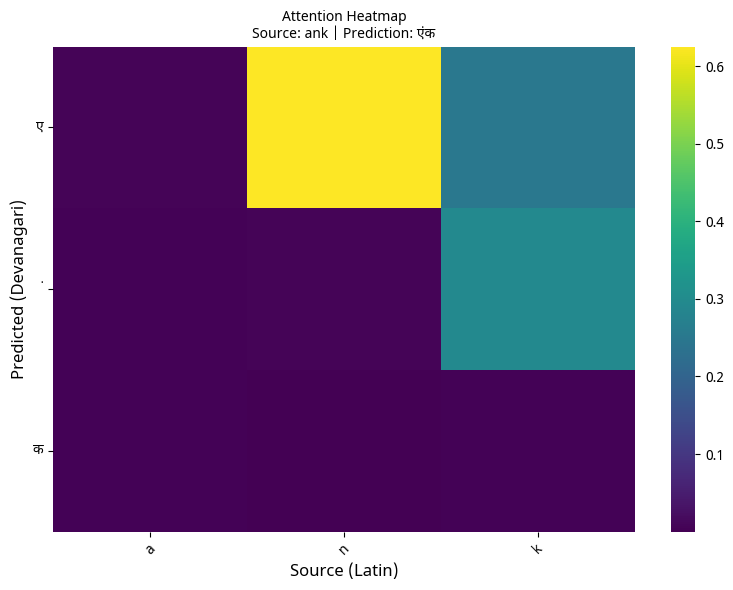

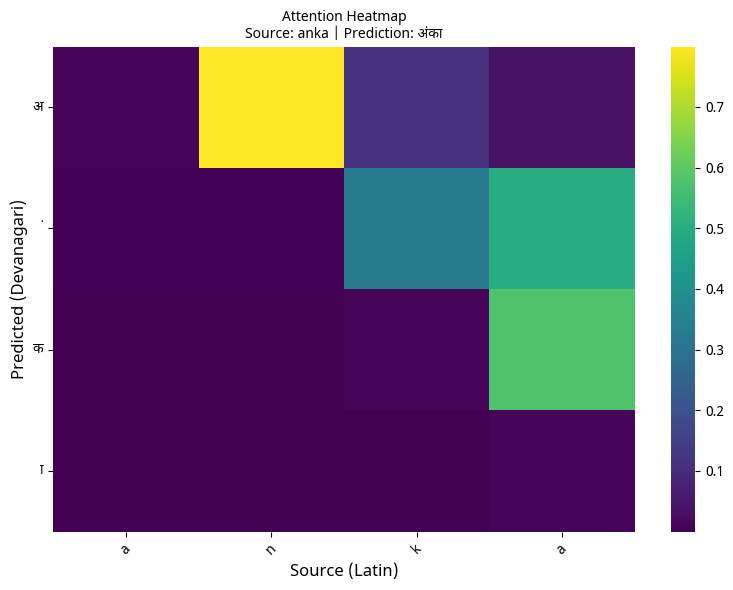

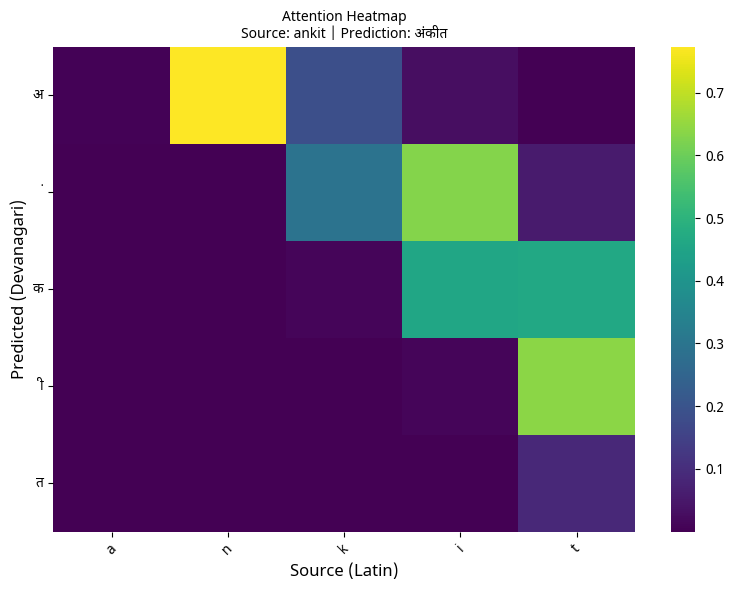

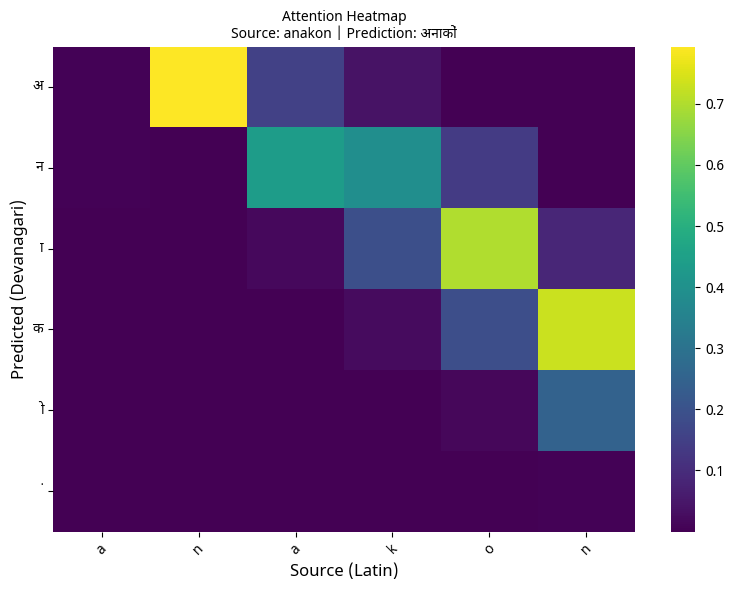

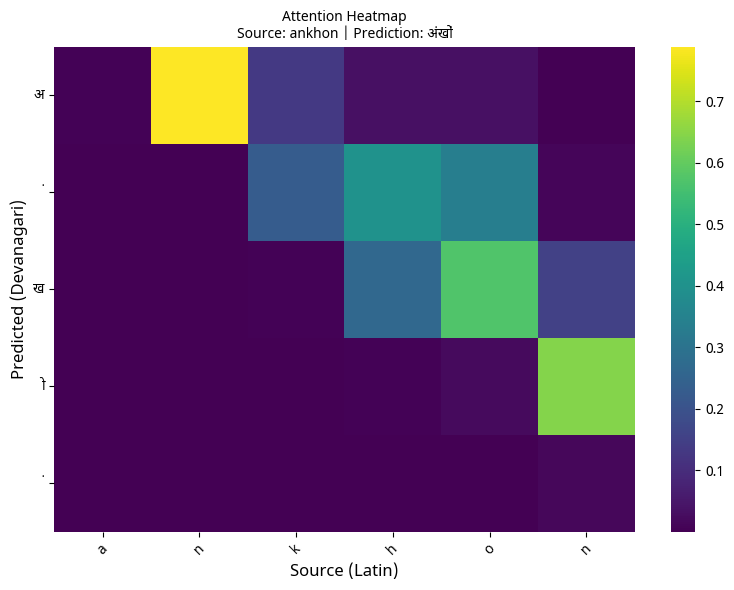

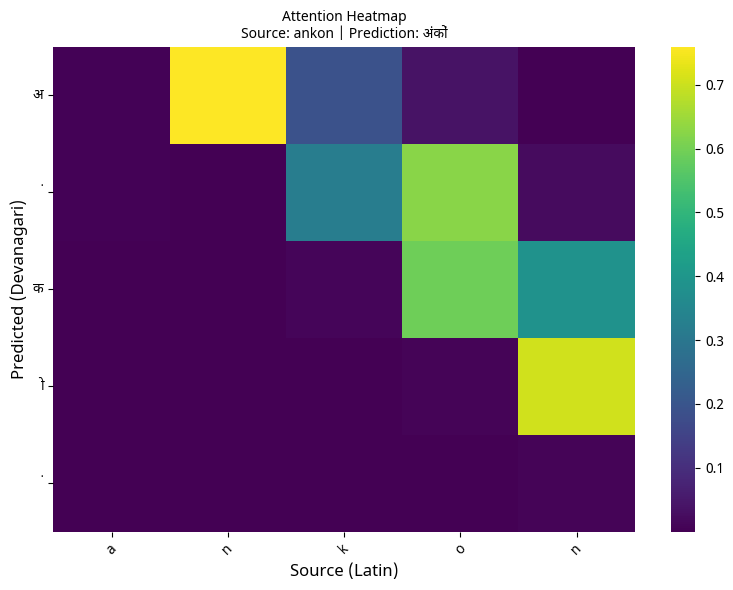

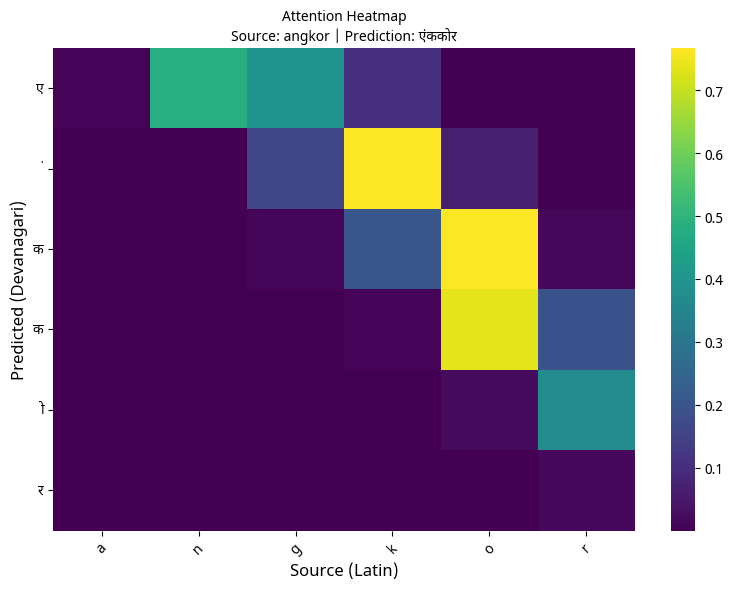

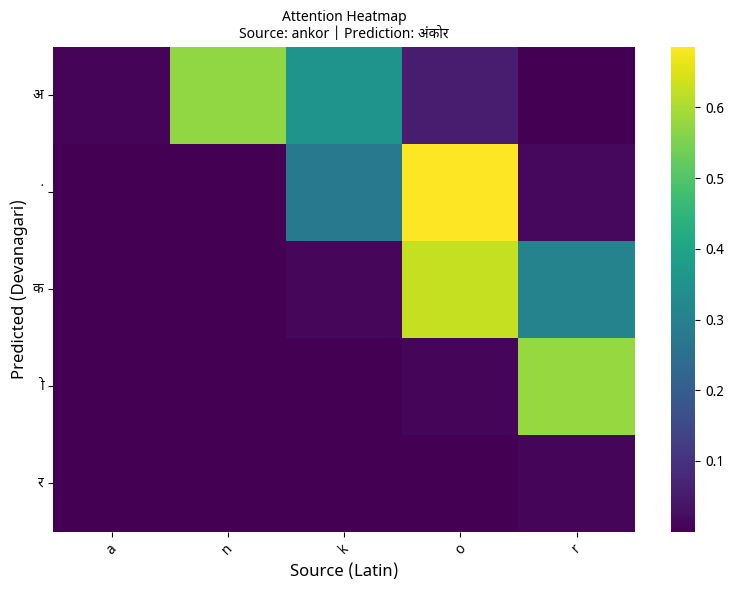

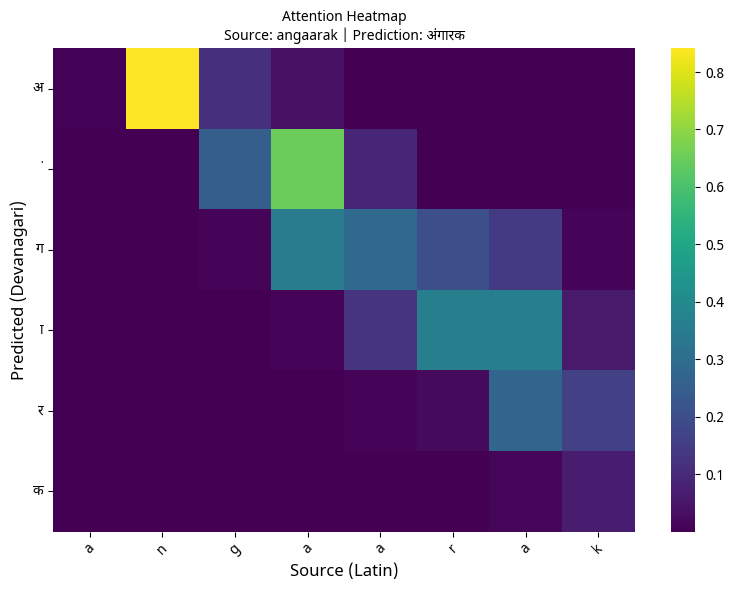

In [16]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
from torch.utils.data import Dataset, DataLoader
import wandb
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import os
import random
import csv
from torch.utils.data import Subset
import torch.nn.functional as F

import matplotlib.pyplot as plt
import matplotlib.font_manager as fm # Make sure this is imported at the top of your script
import seaborn as sns
import os

# ---- Set Seeds for Reproducibility ----
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

# ---- Best Hyperparameters ----
best_hparams = {
    'batch_size': 128,
    'hidden_size': 1024,
    'embedding_dim': 512,
    'dropout': 0.2,
    'cell_type': 'LSTM',
    'num_layers': 2,
    'lr': 0.001,
    'epochs': 4,
    'tf_ratio': 0.8
}

# ---- Data Loading & Vocabulary ----
train_data, dev_data, test_data = load_data('hi')
latin_vocab, devanagari_vocab = create_vocab(pd.concat([train_data, dev_data]))

train_dataset = TransliterationDataset(train_data, latin_vocab, devanagari_vocab)
dev_dataset = TransliterationDataset(dev_data, latin_vocab, devanagari_vocab)
test_dataset = TransliterationDataset(test_data, latin_vocab, devanagari_vocab)

train_loader = DataLoader(train_dataset, batch_size=best_hparams['batch_size'], shuffle=True, collate_fn=collate_fn)
dev_loader = DataLoader(dev_dataset, batch_size=best_hparams['batch_size'], shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=best_hparams['batch_size'], shuffle=False, collate_fn=collate_fn)

# ---- Model Definition ----
encoder = Encoder(len(latin_vocab), best_hparams['embedding_dim'], best_hparams['hidden_size'],
                  dropout=best_hparams['dropout'], cell_type=best_hparams['cell_type'],
                  num_layers=best_hparams['num_layers']).to(device)

decoder = AttnDecoder(len(devanagari_vocab), best_hparams['embedding_dim'], best_hparams['hidden_size'],
                      dropout=best_hparams['dropout'], cell_type=best_hparams['cell_type'],
                      num_layers=best_hparams['num_layers']).to(device)

model = AttnSeq2Seq(encoder, decoder, device).to(device)

optimizer = optim.Adam(model.parameters(), lr=best_hparams['lr'])
criterion = nn.CrossEntropyLoss(ignore_index=0)

# ---- Training Loop ----
for epoch in range(best_hparams['epochs']):
    train_metrics = train(model, train_loader, optimizer, criterion, epoch + 1, latin_vocab, devanagari_vocab, tf_ratio = best_hparams['tf_ratio'])
    val_metrics = evaluate(model, dev_loader, criterion, latin_vocab, devanagari_vocab)
    print(f"Epoch {epoch+1} Validation - Loss: {val_metrics['loss']:.4f} | Word Acc: {val_metrics['word_accuracy']:.4f}")

# ---- Final Evaluation on Test Set ----
test_metrics = evaluate(model, test_loader, criterion, latin_vocab, devanagari_vocab)
print(f"\nTest Set - Loss: {test_metrics['loss']:.4f} | Word Accuracy: {test_metrics['word_accuracy']:.4f} | Char accuracy: {test_metrics['char_accuracy']:.4f}")

# ---- Plot First 9 Test Predictions ----
if len(test_metrics['predictions']) < 9:
    print("Not enough test predictions to plot 9 heatmaps.")
else:
    for i in range(9):
        sample = test_metrics['predictions'][i]
        plot_attention_heatmap(sample)

In [17]:
prediction_data = [{
    'source': sample['source'],
    'target': sample['target'],
    'prediction': sample['prediction'],
    'correct': sample['correct']
} for sample in test_metrics['predictions']]

df = pd.DataFrame(prediction_data)
df.to_csv('test_predictions.csv', index=False)
print("Saved test predictions to 'test_predictions.csv'")

Saved test predictions to 'test_predictions.csv'


In [15]:
# import torch
# import torch.nn as nn
# import torch.optim as optim
# import numpy as np
# import pandas as pd
# from torch.utils.data import Dataset, DataLoader
# import wandb
# from sklearn.model_selection import train_test_split
# import matplotlib.pyplot as plt
# import seaborn as sns
# from tqdm import tqdm
# import os
# import random
# import csv
# from torch.utils.data import Subset
# import torch.nn.functional as F

# import matplotlib.pyplot as plt
# import matplotlib.font_manager as fm # Make sure this is imported at the top of your script
# import seaborn as sns
# import os # Make sure this is imported at the top of your script

# --- Define devanagari_font_prop *before* this function ---
# This part goes *before* any functions that use it, typically near your other imports.
# It should be based on the successful font loading from your previous steps.

font_path = '/kaggle/input/notosans/NotoSansDevanagari-VariableFont_wdthwght.ttf' # **MAKE SURE THIS IS YOUR CORRECT PATH**

devanagari_font_prop = None # Initialize to None
try:
    if os.path.exists(font_path):
        fm.fontManager.addfont(font_path) # Add it to Matplotlib's font manager
        devanagari_font_prop = fm.FontProperties(fname=font_path)
        # Set global rcParams too, as it helps for other elements
        plt.rcParams['font.sans-serif'] = [devanagari_font_prop.get_name(), 'FreeSans', 'DejaVu Sans', 'sans-serif']
        plt.rcParams['font.family'] = 'sans-serif'
        plt.rcParams['axes.unicode_minus'] = False
        print(f"Matplotlib configured using specific font path: {font_path}")
    else:
        print(f"Error: Font file not found at {font_path}. Devanagari text may not render correctly.")
except Exception as e:
    print(f"Error loading or configuring Devanagari font: {e}")
    devanagari_font_prop = None # Ensure it's None if there was an error
# -----------------------------------------------------------


def plot_attention_heatmap(sample):
    source = list(sample['source'])
    target = list(sample['prediction']) # 'target' is the predicted Devanagari word
    attention = sample['attention']  # Shape: [target_len, source_len]

    # Dynamically adjust figure size for better readability
    fig_width = max(8, len(source) * 0.5)
    fig_height = max(6, len(target) * 0.5)

    plt.figure(figsize=(fig_width, fig_height))

    # Create the heatmap
    sns.heatmap(attention, xticklabels=source, yticklabels=target, cmap='viridis')

    # Apply the Devanagari font to elements that should display Devanagari
    if devanagari_font_prop:
        # X-axis label (Source - Latin)
        plt.xlabel('Source (Latin)', fontsize=12) # No font_properties here if Latin

        # Y-axis label (Predicted - Devanagari)
        plt.ylabel('Predicted (Devanagari)', fontsize=12, **{'fontproperties': devanagari_font_prop})

        # Title (contains both Latin and Devanagari)
        plt.title(f"Attention Heatmap\nSource: {sample['source']} | Prediction: {sample['prediction']}", fontsize=14, **{'fontproperties': devanagari_font_prop})

        # Apply font to Y-axis tick labels (the predicted Devanagari characters)
        for tick_label in plt.gca().get_yticklabels():
            tick_label.set_fontproperties(devanagari_font_prop)

        # Apply font to X-axis tick labels (source characters - generally Latin, but good to ensure if needed)
        # You might not need this if source characters are always Latin and your default font handles them.
        # However, if your source characters could ever be complex or have mixed scripts, it's safer.
        for tick_label in plt.gca().get_xticklabels():
            # You could add a check here if characters are Devanagari:
            # if any('\u0900' <= char <= '\u097F' for char in tick_label.get_text()):
            tick_label.set_fontproperties(devanagari_font_prop)

    else:
        # Fallback if font could not be loaded or prop is None
        plt.xlabel('Source (Latin)', fontsize=12)
        plt.ylabel('Predicted (Devanagari)', fontsize=12)
        plt.title(f"Attention Heatmap\nSource: {sample['source']} | Prediction: {sample['prediction']}", fontsize=14)

    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show() # Or wandb.Image(fig) if logging to wandb

# # Load data
# train_data, dev_data, test_data = load_data('hi')
# latin_vocab, devanagari_vocab = create_vocab(pd.concat([train_data, dev_data]))
# train_dataset = TransliterationDataset(train_data, latin_vocab, devanagari_vocab)
# dev_dataset = TransliterationDataset(dev_data, latin_vocab, devanagari_vocab)
# test_dataset = TransliterationDataset(test_data, latin_vocab, devanagari_vocab)

# train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, collate_fn=collate_fn)
# dev_loader = DataLoader(dev_dataset, batch_size=128, shuffle=False, collate_fn=collate_fn)
# test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, collate_fn=collate_fn)

# encoder = Encoder(len(latin_vocab), 256, 512,
#                   dropout=0.2, cell_type='LSTM', num_layers=2).to(device)
# decoder = AttnDecoder(len(devanagari_vocab), 128, 512,
#                       dropout=0.2, cell_type='LSTM', num_layers=2).to(device)

# model = AttnSeq2Seq(encoder, decoder, device).to(device)

# optimizer = optim.Adam(model.parameters(), lr=0.001)
# criterion = nn.CrossEntropyLoss(ignore_index=0)

# # best_val_word_accuracy = 0
# for epoch in range(1):
#     train_metrics = train(model, train_loader, optimizer, criterion, 1, latin_vocab, devanagari_vocab, tf_ratio=)
#     val_metrics = evaluate(model, dev_loader, criterion, latin_vocab, devanagari_vocab)

#     print(f"\nEpoch {epoch+1} Validation - Loss: {val_metrics['loss']:.4f} | Word Acc: {val_metrics['word_accuracy']:.4f}")

#     # Plot attention heatmap for a sample prediction
#     sample = val_metrics['predictions'][0]
#     plot_attention_heatmap(sample)

Matplotlib configured using specific font path: /kaggle/input/notosans/NotoSansDevanagari-VariableFont_wdthwght.ttf


In [11]:
import wandb
wandb.login(key="559009604832a12ab57d01a86b6119ec05637a17")

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: eshan_kulkarni (eshan_kulkarni-indian-institute-of-technology-madras) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [12]:

import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import os
import random
import csv
from torch.utils.data import Subset
import torch.nn.functional as F

def train_with_sweep():
    wandb.init()
    config = wandb.config

    # Load data
    train_data, dev_data, test_data = load_data('hi')
    latin_vocab, devanagari_vocab = create_vocab(pd.concat([train_data, dev_data]))
    train_dataset = TransliterationDataset(train_data, latin_vocab, devanagari_vocab)
    dev_dataset = TransliterationDataset(dev_data, latin_vocab, devanagari_vocab)
    test_dataset = TransliterationDataset(test_data, latin_vocab, devanagari_vocab)

    train_loader = DataLoader(train_dataset, batch_size=config.batch_size, shuffle=True, collate_fn=collate_fn)
    dev_loader = DataLoader(dev_dataset, batch_size=config.batch_size, shuffle=False, collate_fn=collate_fn)
    test_loader = DataLoader(test_dataset, batch_size=config.batch_size, shuffle=False, collate_fn=collate_fn)

    encoder = Encoder(len(latin_vocab), config.enc_emb_dim, config.hid_dim,
                      dropout=config.enc_dropout, cell_type=config.cell_type, num_layers=config.num_layers).to(device)

    decoder = AttnDecoder(len(devanagari_vocab), config.dec_emb_dim, config.hid_dim,
                          dropout=config.dec_dropout, cell_type=config.cell_type, num_layers=config.num_layers).to(device)

    model = AttnSeq2Seq(encoder, decoder, device).to(device)

    optimizer = optim.Adam(model.parameters(), lr=config.lr)
    criterion = nn.CrossEntropyLoss(ignore_index=0)

    best_val_word_accuracy = 0
    for epoch in range(config.epochs):
        train_metrics = train(model, train_loader, optimizer, criterion, config.clip, latin_vocab, devanagari_vocab, tf_ratio=config.tf_ratio)
        val_metrics = evaluate(model, dev_loader, criterion, latin_vocab, devanagari_vocab)

        wandb.log({
            'epoch': epoch,
            'train_loss': train_metrics['loss'],
            'train_char_acc': train_metrics['char_accuracy'],
            'train_word_acc': train_metrics['word_accuracy'],
            'val_loss': val_metrics['loss'],
            'val_char_acc': val_metrics['char_accuracy'],
            'val_word_acc': val_metrics['word_accuracy']
        })
        # print(val_metrics['attentions'])
        # if val_metrics['word_accuracy'] > best_val_word_accuracy:
        #     best_val_word_accuracy = val_metrics['word_accuracy']
        #     torch.save(model.state_dict(), 'best_model.pt')


# === Sweep Config ===
sweep_config = {
    'method': 'bayes',
    'metric': {
        'name': 'val_word_acc',
        'goal': 'maximize'
    },
    'parameters': {
        'batch_size': {'values': [64, 128]},
        'enc_emb_dim': {'values': [256, 512]},
        'dec_emb_dim': {'values': [256, 512]},
        'hid_dim': {'values': [512, 1024]},
        'enc_dropout': {'values':[0.3, 0.2]},
        'dec_dropout': {'values': [0.1, 0.2]},
        'epochs': {'value': 4},
        'clip': {'value': 1},
        'lr': {'values':[0.00005,0.0005, 0.001]},
        'cell_type': {'values': ['LSTM']},
        'num_layers':{'values': [2,3]},
        'tf_ratio':{'values':[0.2, 0.5, 0.8]}
    }
}


if __name__ == '__main__':
    sweep_id = wandb.sweep(sweep_config, project='DA6401-Assignment3-Attention')
    wandb.agent(sweep_id, function=train_with_sweep, count = 10)

Create sweep with ID: u2hg725y
Sweep URL: https://wandb.ai/eshan_kulkarni-indian-institute-of-technology-madras/DA6401-Assignment3-Attention/sweeps/u2hg725y


wandb: Agent Starting Run: b0mx01vx with config:
wandb: 	batch_size: 128
wandb: 	cell_type: LSTM
wandb: 	clip: 1
wandb: 	dec_dropout: 0.1
wandb: 	dec_emb_dim: 256
wandb: 	enc_dropout: 0.3
wandb: 	enc_emb_dim: 512
wandb: 	epochs: 4
wandb: 	hid_dim: 512
wandb: 	lr: 0.001
wandb: 	num_layers: 2
wandb: 	tf_ratio: 0.8
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


/tmp/ipykernel_31/3409640308.py:18: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  train_data = train_data.applymap(lambda x: str(x).strip())
/tmp/ipykernel_31/3409640308.py:19: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  dev_data = dev_data.applymap(lambda x: str(x).strip())
/tmp/ipykernel_31/3409640308.py:20: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  test_data = test_data.applymap(lambda x: str(x).strip())
Training: 100%|██████████| 346/346 [00:29<00:00, 11.55it/s]


epoch,▁▃▆█
train_char_acc,▁▆▇█
train_loss,█▃▂▁
train_word_acc,▁███
val_char_acc,▁▄▇█
val_loss,█▅▁▂
val_word_acc,▁▆▇█
epoch,3
train_char_acc,0.85815
train_loss,0.4692
train_word_acc,0.41


wandb: Agent Starting Run: jdu2fpe2 with config:
wandb: 	batch_size: 128
wandb: 	cell_type: LSTM
wandb: 	clip: 1
wandb: 	dec_dropout: 0.2
wandb: 	dec_emb_dim: 256
wandb: 	enc_dropout: 0.3
wandb: 	enc_emb_dim: 256
wandb: 	epochs: 4
wandb: 	hid_dim: 512
wandb: 	lr: 0.0005
wandb: 	num_layers: 3
wandb: 	tf_ratio: 0.5


/tmp/ipykernel_31/3409640308.py:18: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  train_data = train_data.applymap(lambda x: str(x).strip())
/tmp/ipykernel_31/3409640308.py:19: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  dev_data = dev_data.applymap(lambda x: str(x).strip())
/tmp/ipykernel_31/3409640308.py:20: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  test_data = test_data.applymap(lambda x: str(x).strip())
Training: 100%|██████████| 346/346 [00:36<00:00,  9.55it/s]


epoch,▁▃▆█
train_char_acc,▁▆▇█
train_loss,█▃▂▁
train_word_acc,▁█▄▇
val_char_acc,▁▅▇█
val_loss,█▅▃▁
val_word_acc,▁▅▇█
epoch,3
train_char_acc,0.81464
train_loss,0.60916
train_word_acc,0.25


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: u8yliyqr with config:
wandb: 	batch_size: 64
wandb: 	cell_type: LSTM
wandb: 	clip: 1
wandb: 	dec_dropout: 0.1
wandb: 	dec_emb_dim: 256
wandb: 	enc_dropout: 0.2
wandb: 	enc_emb_dim: 512
wandb: 	epochs: 4
wandb: 	hid_dim: 512
wandb: 	lr: 0.0005
wandb: 	num_layers: 3
wandb: 	tf_ratio: 0.5


/tmp/ipykernel_31/3409640308.py:18: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  train_data = train_data.applymap(lambda x: str(x).strip())
/tmp/ipykernel_31/3409640308.py:19: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  dev_data = dev_data.applymap(lambda x: str(x).strip())
/tmp/ipykernel_31/3409640308.py:20: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  test_data = test_data.applymap(lambda x: str(x).strip())
Training: 100%|██████████| 691/691 [00:43<00:00, 15.87it/s]


epoch,▁▃▆█
train_char_acc,▁▆▇█
train_loss,█▂▂▁
train_word_acc,▁▆▆█
val_char_acc,▁▆██
val_loss,█▃▁▂
val_word_acc,▁▆▇█
epoch,3
train_char_acc,0.8443
train_loss,0.51254
train_word_acc,0.44


wandb: Agent Starting Run: s3c2bqwt with config:
wandb: 	batch_size: 128
wandb: 	cell_type: LSTM
wandb: 	clip: 1
wandb: 	dec_dropout: 0.1
wandb: 	dec_emb_dim: 512
wandb: 	enc_dropout: 0.2
wandb: 	enc_emb_dim: 256
wandb: 	epochs: 4
wandb: 	hid_dim: 512
wandb: 	lr: 0.0005
wandb: 	num_layers: 3
wandb: 	tf_ratio: 0.8


/tmp/ipykernel_31/3409640308.py:18: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  train_data = train_data.applymap(lambda x: str(x).strip())
/tmp/ipykernel_31/3409640308.py:19: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  dev_data = dev_data.applymap(lambda x: str(x).strip())
/tmp/ipykernel_31/3409640308.py:20: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  test_data = test_data.applymap(lambda x: str(x).strip())
Training: 100%|██████████| 346/346 [00:37<00:00,  9.21it/s]


epoch,▁▃▆█
train_char_acc,▁▆▇█
train_loss,█▂▂▁
train_word_acc,▁▄█▆
val_char_acc,▁▅▇█
val_loss,█▅▂▁
val_word_acc,▁▆██
epoch,3
train_char_acc,0.82973
train_loss,0.56147
train_word_acc,0.3


wandb: Agent Starting Run: 1rj44a67 with config:
wandb: 	batch_size: 128
wandb: 	cell_type: LSTM
wandb: 	clip: 1
wandb: 	dec_dropout: 0.2
wandb: 	dec_emb_dim: 256
wandb: 	enc_dropout: 0.3
wandb: 	enc_emb_dim: 512
wandb: 	epochs: 4
wandb: 	hid_dim: 1024
wandb: 	lr: 0.001
wandb: 	num_layers: 2
wandb: 	tf_ratio: 0.8


/tmp/ipykernel_31/3409640308.py:18: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  train_data = train_data.applymap(lambda x: str(x).strip())
/tmp/ipykernel_31/3409640308.py:19: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  dev_data = dev_data.applymap(lambda x: str(x).strip())
/tmp/ipykernel_31/3409640308.py:20: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  test_data = test_data.applymap(lambda x: str(x).strip())
Training: 100%|██████████| 346/346 [01:34<00:00,  3.66it/s]


epoch,▁▃▆█
train_char_acc,▁▆▇█
train_loss,█▃▂▁
train_word_acc,▁▅▄█
val_char_acc,▁▆██
val_loss,█▃▁▁
val_word_acc,▁▆██
epoch,3
train_char_acc,0.87751
train_loss,0.40384
train_word_acc,0.59


wandb: Agent Starting Run: i4qsqs47 with config:
wandb: 	batch_size: 128
wandb: 	cell_type: LSTM
wandb: 	clip: 1
wandb: 	dec_dropout: 0.2
wandb: 	dec_emb_dim: 256
wandb: 	enc_dropout: 0.3
wandb: 	enc_emb_dim: 512
wandb: 	epochs: 4
wandb: 	hid_dim: 1024
wandb: 	lr: 0.001
wandb: 	num_layers: 2
wandb: 	tf_ratio: 0.5


/tmp/ipykernel_31/3409640308.py:18: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  train_data = train_data.applymap(lambda x: str(x).strip())
/tmp/ipykernel_31/3409640308.py:19: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  dev_data = dev_data.applymap(lambda x: str(x).strip())
/tmp/ipykernel_31/3409640308.py:20: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  test_data = test_data.applymap(lambda x: str(x).strip())
Training: 100%|██████████| 346/346 [01:34<00:00,  3.67it/s]


epoch,▁▃▆█
train_char_acc,▁▆▇█
train_loss,█▃▂▁
train_word_acc,▁▃█▄
val_char_acc,▁▆██
val_loss,█▅▁▄
val_word_acc,▁▅██
epoch,3
train_char_acc,0.87412
train_loss,0.41522
train_word_acc,0.38


wandb: Agent Starting Run: 219jcmv2 with config:
wandb: 	batch_size: 128
wandb: 	cell_type: LSTM
wandb: 	clip: 1
wandb: 	dec_dropout: 0.2
wandb: 	dec_emb_dim: 512
wandb: 	enc_dropout: 0.3
wandb: 	enc_emb_dim: 512
wandb: 	epochs: 4
wandb: 	hid_dim: 1024
wandb: 	lr: 0.001
wandb: 	num_layers: 2
wandb: 	tf_ratio: 0.2


/tmp/ipykernel_31/3409640308.py:18: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  train_data = train_data.applymap(lambda x: str(x).strip())
/tmp/ipykernel_31/3409640308.py:19: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  dev_data = dev_data.applymap(lambda x: str(x).strip())
/tmp/ipykernel_31/3409640308.py:20: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  test_data = test_data.applymap(lambda x: str(x).strip())
Training: 100%|██████████| 346/346 [01:35<00:00,  3.61it/s]


epoch,▁▃▆█
train_char_acc,▁▆▇█
train_loss,█▃▂▁
train_word_acc,▁▂▆█
val_char_acc,▁▆▇█
val_loss,█▁▂▁
val_word_acc,▁▆██
epoch,3
train_char_acc,0.87875
train_loss,0.4013
train_word_acc,0.52


wandb: Agent Starting Run: 7i6o0jno with config:
wandb: 	batch_size: 128
wandb: 	cell_type: LSTM
wandb: 	clip: 1
wandb: 	dec_dropout: 0.2
wandb: 	dec_emb_dim: 512
wandb: 	enc_dropout: 0.2
wandb: 	enc_emb_dim: 512
wandb: 	epochs: 4
wandb: 	hid_dim: 1024
wandb: 	lr: 0.001
wandb: 	num_layers: 2
wandb: 	tf_ratio: 0.8


/tmp/ipykernel_31/3409640308.py:18: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  train_data = train_data.applymap(lambda x: str(x).strip())
/tmp/ipykernel_31/3409640308.py:19: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  dev_data = dev_data.applymap(lambda x: str(x).strip())
/tmp/ipykernel_31/3409640308.py:20: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  test_data = test_data.applymap(lambda x: str(x).strip())
Training: 100%|██████████| 346/346 [01:36<00:00,  3.59it/s]


epoch,▁▃▆█
train_char_acc,▁▆▇█
train_loss,█▃▂▁
train_word_acc,▁▄██
val_char_acc,▁▅▆█
val_loss,█▄▁▁
val_word_acc,▁▄▆█
epoch,3
train_char_acc,0.87877
train_loss,0.40007
train_word_acc,0.47


wandb: Agent Starting Run: wb220gb9 with config:
wandb: 	batch_size: 128
wandb: 	cell_type: LSTM
wandb: 	clip: 1
wandb: 	dec_dropout: 0.1
wandb: 	dec_emb_dim: 512
wandb: 	enc_dropout: 0.2
wandb: 	enc_emb_dim: 512
wandb: 	epochs: 4
wandb: 	hid_dim: 1024
wandb: 	lr: 0.001
wandb: 	num_layers: 2
wandb: 	tf_ratio: 0.5


/tmp/ipykernel_31/3409640308.py:18: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  train_data = train_data.applymap(lambda x: str(x).strip())
/tmp/ipykernel_31/3409640308.py:19: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  dev_data = dev_data.applymap(lambda x: str(x).strip())
/tmp/ipykernel_31/3409640308.py:20: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  test_data = test_data.applymap(lambda x: str(x).strip())
Training: 100%|██████████| 346/346 [01:36<00:00,  3.60it/s]


epoch,▁▃▆█
train_char_acc,▁▆▇█
train_loss,█▃▂▁
train_word_acc,▁▆██
val_char_acc,▁▆██
val_loss,█▃▂▁
val_word_acc,▁▅█▃
epoch,3
train_char_acc,0.88485
train_loss,0.38098
train_word_acc,0.5


wandb: Agent Starting Run: p5yuwh38 with config:
wandb: 	batch_size: 128
wandb: 	cell_type: LSTM
wandb: 	clip: 1
wandb: 	dec_dropout: 0.2
wandb: 	dec_emb_dim: 512
wandb: 	enc_dropout: 0.3
wandb: 	enc_emb_dim: 512
wandb: 	epochs: 4
wandb: 	hid_dim: 1024
wandb: 	lr: 0.001
wandb: 	num_layers: 2
wandb: 	tf_ratio: 0.8


/tmp/ipykernel_31/3409640308.py:18: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  train_data = train_data.applymap(lambda x: str(x).strip())
/tmp/ipykernel_31/3409640308.py:19: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  dev_data = dev_data.applymap(lambda x: str(x).strip())
/tmp/ipykernel_31/3409640308.py:20: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  test_data = test_data.applymap(lambda x: str(x).strip())
Training: 100%|██████████| 346/346 [01:35<00:00,  3.62it/s]


epoch,▁▃▆█
train_char_acc,▁▆▇█
train_loss,█▃▂▁
train_word_acc,▃▁█▅
val_char_acc,▁▅▇█
val_loss,█▁▁▂
val_word_acc,▁▄█▄
epoch,3
train_char_acc,0.88
train_loss,0.39582
train_word_acc,0.31


# Question 6

In [25]:
def animate_attention(sample, font_prop=None):
    source = list(sample['source'])
    target = list(sample['prediction'])
    attention = sample['attention']  # Shape: [target_len, source_len]

    fig_width = max(2.5, len(source) * 0.6)
    fig, ax = plt.subplots(figsize=(fig_width, 1.8))
    ax.axis('off')

    ax.set_xlim(-0.5, len(source) - 0.5)
    ax.set_ylim(0, 1)

    # Normalize attention weights for color mapping
    norm = mcolors.Normalize(vmin=0, vmax=1)
    cmap = plt.get_cmap('YlOrBr')

    # Display source characters with background boxes
    text_objs = []
    for i, char in enumerate(source):
        txt = ax.text(i, 0.5, char, fontsize=14, ha='center', va='center',
                      weight='bold', fontproperties=font_prop,
                      bbox=dict(facecolor='white', edgecolor='none', boxstyle='round,pad=0.25'))
        text_objs.append(txt)

    # Dynamic title for target char
    title = ax.text(0.5, 0.92, '', transform=ax.transAxes,
                    ha='center', va='bottom', fontsize=14, fontproperties=font_prop, weight='bold')

    def update(frame):
        weights = attention[frame]
        tgt_char = target[frame]
        title.set_text(f"Generating: '{tgt_char}'")

        for i, weight in enumerate(weights):
            color = cmap(norm(weight))
            text_objs[i].set_bbox(dict(facecolor=color, edgecolor='none', boxstyle='round,pad=0.25'))

        return text_objs + [title]

    ani = FuncAnimation(fig, update, frames=len(target), interval=1000, blit=True, repeat=True)
    plt.close(fig)
    return HTML(ani.to_jshtml())

In [26]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib import colors as mcolors
from IPython.display import HTML, display

# Show attention animations for first 4 predictions
for i in range(4):
    print(f"Sample {i + 1}:")
    display(animate_attention(test_metrics['predictions'][i]))

Sample 1:


Sample 2:


Sample 3:


Sample 4:
